In [12]:
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

In [3]:
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

def annotate_cpgs(segments):
    segments["CpGs"] = segments.apply(lambda row: set(reference_cpgs.get_CGs(row["chrom"], row["start"], row["end"])), axis=1)

In [4]:
ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"

gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
annotate_cpgs(gt)

In [5]:
""" Load the actual, measurable differential methylation in ground truth regions """
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"
with MetH5File(simulated_m5, "r") as simulated_m5, tqdm.tqdm(total=gt.shape[0]) as pbar:
    def compute_diffmet(chrom, start, end):
        agg = simulated_m5[chrom].get_values_in_range(start, end).get_llr_site_readgroup_rate("sample")
        diffmet = np.abs(np.nanmean(agg[1][0]) - np.nanmean(agg[2][0]))
        pbar.update(1)
        return diffmet
    gt["diffmet"] = gt.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [06:35<00:00, 17.29it/s]


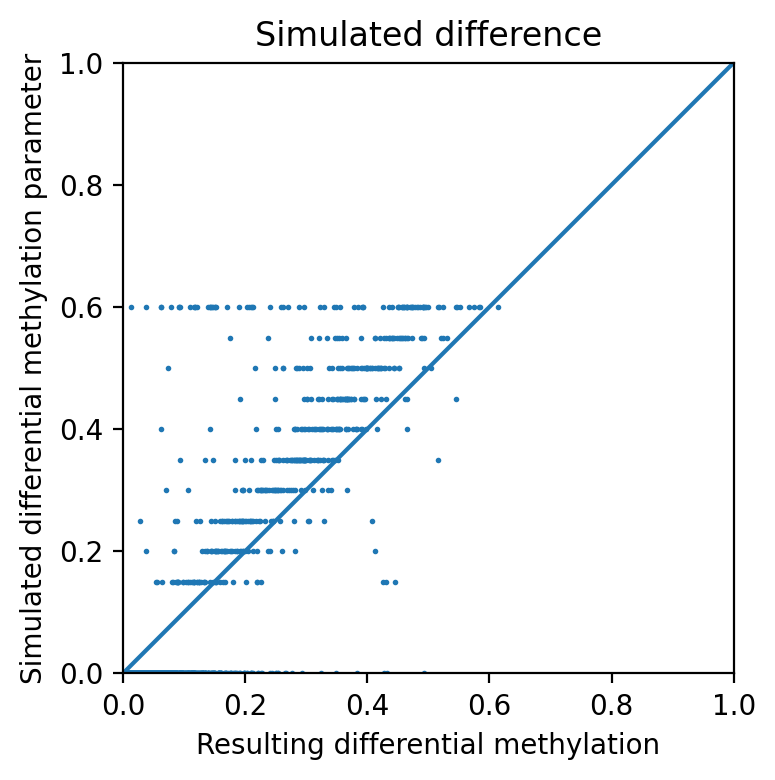

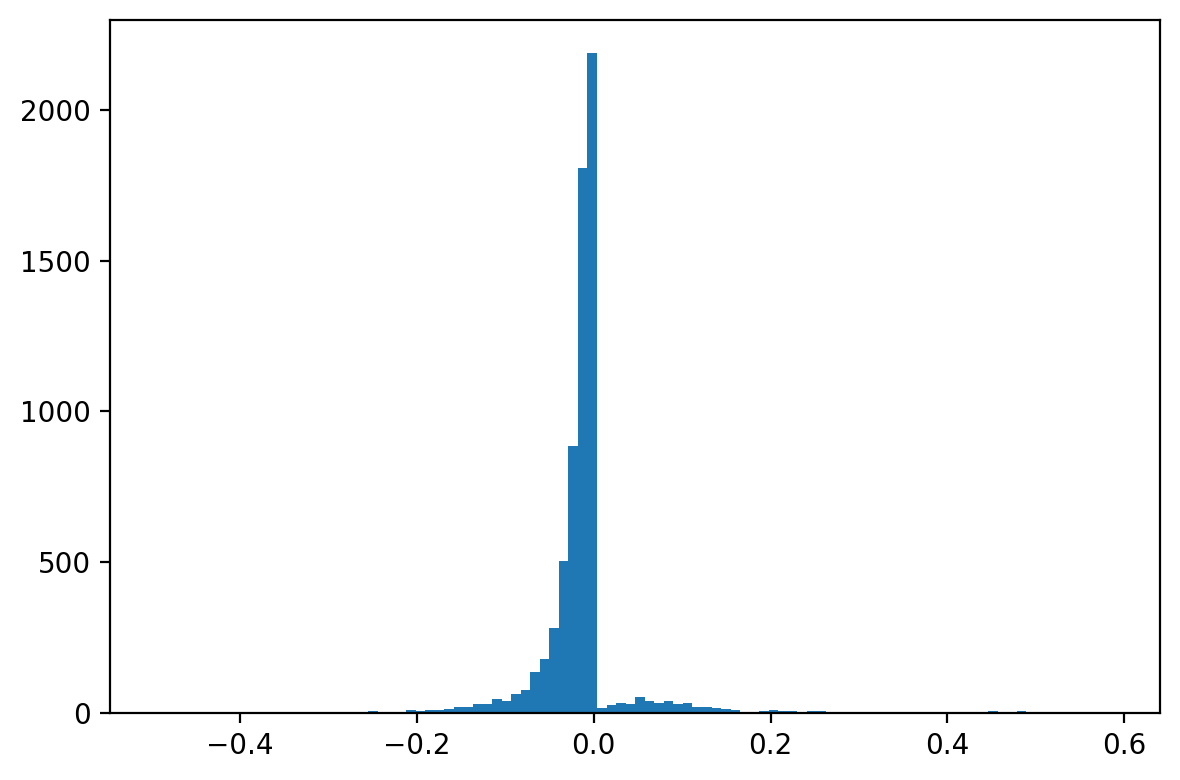

In [6]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(gt["diffmet"], np.abs(gt["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(gt["theta"]) - gt["diffmet"], bins=100)
plt.show()

In [93]:

methcp_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_highpval_dmr.bed"
methcp_dmrs = pd.read_csv(methcp_dmrs_file, sep="\t", names=["chrom", "start", "end", "nC.valid", "nC", "diffmet", "cov", "pval"], dtype={"chrom":str})
#methcp_dmrs = methcp_dmrs.loc[(methcp_dmrs["nC.valid"]>10)]
annotate_cpgs(methcp_dmrs)

,chrom,start,end,nC.valid,nC,diffmet,cov,pval,CpGs
0,1,68848,70916,17,17,0.1104,18.1471,0.443659,"{69766, 70664, 70804, 68888, 69535, 69550, 695..."
1,1,252847,253855,5,5,-0.1489,24.3000,0.029243,"{253514, 253004, 252901, 252847}"
2,1,317974,319498,14,14,0.1230,20.7143,0.000414,"{317987, 319459, 318696, 317998, 318480, 31803..."
3,1,346983,347693,5,5,-0.1403,21.6000,0.161248,"{347657, 347165, 346983, 347061}"
4,1,381974,382896,6,6,0.1575,18.2500,0.377120,"{382438, 382603, 382190, 381974, 382559}"
...,...,...,...,...,...,...,...,...,...
3804,1,248471466,248472614,10,10,-0.2013,20.4500,0.001299,"{248472288, 248471906, 248472228, 248471941, 2..."
3805,1,248477640,248478442,6,6,-0.1353,22.5833,0.028698,"{248477827, 248477640, 248478386, 248477976, 2..."
3806,1,248583811,248584393,9,9,-0.1090,23.7778,0.035234,"{248583841, 248583811, 248584059, 248583881, 2..."
3807,1,248704833,248705623,11,11,-0.1365,20.5455,0.062396,"{248704833, 248705604, 248705162, 248704907, 2..."


In [87]:
pycometh_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet.tsv"
pycometh_dmrs = pd.read_csv(pycometh_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_dmrs["diffmet"] = pycometh_dmrs["difference"].map(lambda x: float(x[1:-1]))
pycometh_dmrs = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.5].copy()
annotate_cpgs(pycometh_dmrs)

In [89]:
pycometh_llr_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_llrdiff.tsv"
pycometh_llr_dmrs = pd.read_csv(pycometh_llr_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_llr_dmrs["diffmet"] = pycometh_llr_dmrs["difference"].map(lambda x: float(x[1:-1]))
pycometh_llr_dmrs = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.5].copy()
annotate_cpgs(pycometh_llr_dmrs)

In [183]:
class ResultComparer:
    def __init__(self, segments):
        self.segments = segments

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=diffmet_threshold, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=diffmet_threshold, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)
        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=diffmet_threshold, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=diffmet_threshold, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

In [117]:
rc = ResultComparer({"GT":gt, "MethCP":methcp_dmrs, "PycoMeth":pycometh_dmrs})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [135]:
print("MethCP TPR", rc.compute_tpr("GT", "MethCP"))
print("MethCP FPR", rc.compute_fpr("GT", "MethCP"))
print("MethCP Precision", rc.compute_precision("GT",  "MethCP"))
print("MethCP FDR", rc.compute_fdr("GT", "MethCP"))

MethCP TPR 0.896879581905353
23116 2166468
MethCP FPR 0.010669901424807567
MethCP Precision 0.8117942079252257
MethCP FDR 0.18820579207477428


In [97]:
print("PycoMeth TPR", rc.compute_tpr("GT", "PycoMeth"))
print("PycoMeth FPR", rc.compute_fpr("GT",  "PycoMeth"))
print("PycoMeth Precision", rc.compute_precision("GT",  "PycoMeth"))
print("PycoMeth FDR", rc.compute_fdr("GT",  "PycoMeth"))

PycoMeth TPR 0.8913835442696386
PycoMeth FPR 0.009158685934894953
PycoMeth Precision 0.8331735862382081
PycoMeth FDR 0.16682641376179186


In [120]:
test = rc.get("GT", diffmet_threshold=0.1, below_threshold=True, theta_threshold=0.1)
print(len(unions(test["CpGs"])))
print(len(unions(rc.get("GT")["CpGs"])))
print(len(unions(gt["CpGs"])))

2166468
112838
2277639


In [181]:
def plot_roc(gt, title="", figurename=None):
    tools = {"MethCP":"b", "PycoMeth":"orange", "PycoMeth LLR": "red"}
    ps = np.arange(0.001, 0.5, 0.025)
    recall = {t:[] for t in tools}
    precision = {t:[] for t in tools}
    for p in ps:
        filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<p].copy()
        filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<p].copy()
        filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<p].copy()
        rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr})
        rc.remove_cpgs_not_in_gt(gt_key="GT")
        for tool in tools:
            recall[tool].append(rc.compute_tpr("GT", tool))
            precision[tool].append(1-rc.compute_fdr("GT", tool))
    o5_index = np.argmin(np.abs((ps-0.05)))


    fig, ((ax1, ax2), (ax3, ax4)) = pa.subplots(2,2, figsize=(15, 10))
    ax1.set_title("Recall")
    for tool, color in tools.items():
        ax1.scatter(ps,recall[tool], label=tool, c=color)


    ax2.set_title("Precision")
    for tool, color in tools.items():
        ax2.scatter(ps,precision[tool], label=tool, c=color)

    ax3.set_title(title)
    for tool, color in tools.items():
        auc = np.nansum(recall[tool] * np.diff(precision[tool], prepend=0))
        ax3.plot(precision[tool],recall[tool], label=f"{tool} AUC={auc:.2f}", c=color)
        ax3.scatter([precision[tool][o5_index]], [recall[tool][o5_index]], c=color)
    ax3.legend()
    ax3.set_ylabel("Recall")
    ax3.set_xlabel("Precision")
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_aspect("equal")
    pa.saveandshow(figurename)


def plot_roc_over_effect_size(gt, title="", figurename=None):
    tools = {"MethCP":"b", "PycoMeth":"orange", "PycoMeth LLR": "red"}
    ess = np.arange(0.1, 0.6, 0.1)
    recall = {t:[] for t in tools}
    precision = {t:[] for t in tools}
    filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
    filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
    filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
    rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr})
    rc.remove_cpgs_not_in_gt(gt_key="GT")
    for es in ess:
        for tool in tools:
            recall[tool].append(rc.compute_tpr("GT", tool, theta_threshold=es))
            precision[tool].append(1-rc.compute_fdr("GT", tool, diffmet_threshold=es))

    o5_index = np.argmin(np.abs((ess-0.5)))


    fig, ((ax1, ax2), (ax3, ax4)) = pa.subplots(2,2, figsize=(15, 10))
    ax1.set_title("Recall")
    for tool, color in tools.items():
        ax1.scatter(ess,recall[tool], label=tool, c=color)
    ax1.set_ylabel("Recall")
    ax1.set_xlabel("Effect size")

    ax2.set_title("Precision")
    for tool, color in tools.items():
        ax2.scatter(ess,precision[tool], label=tool, c=color)
    ax2.set_ylabel("Precision")
    ax1.set_xlabel("Effect size")

    ax3.set_title(title)
    for tool, color in tools.items():
        auc = np.nansum((recall[tool] * np.diff(precision[tool], prepend=0)))
        ax3.plot(precision[tool],recall[tool], label=f"{tool} AUC={auc:.2f}", c=color)
        ax3.scatter([precision[tool][o5_index]], [recall[tool][o5_index]], c=color)
    ax3.legend()
    ax3.set_ylabel("Recall")
    ax3.set_xlabel("Precision")
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_aspect("equal")
    pa.saveandshow(figurename)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


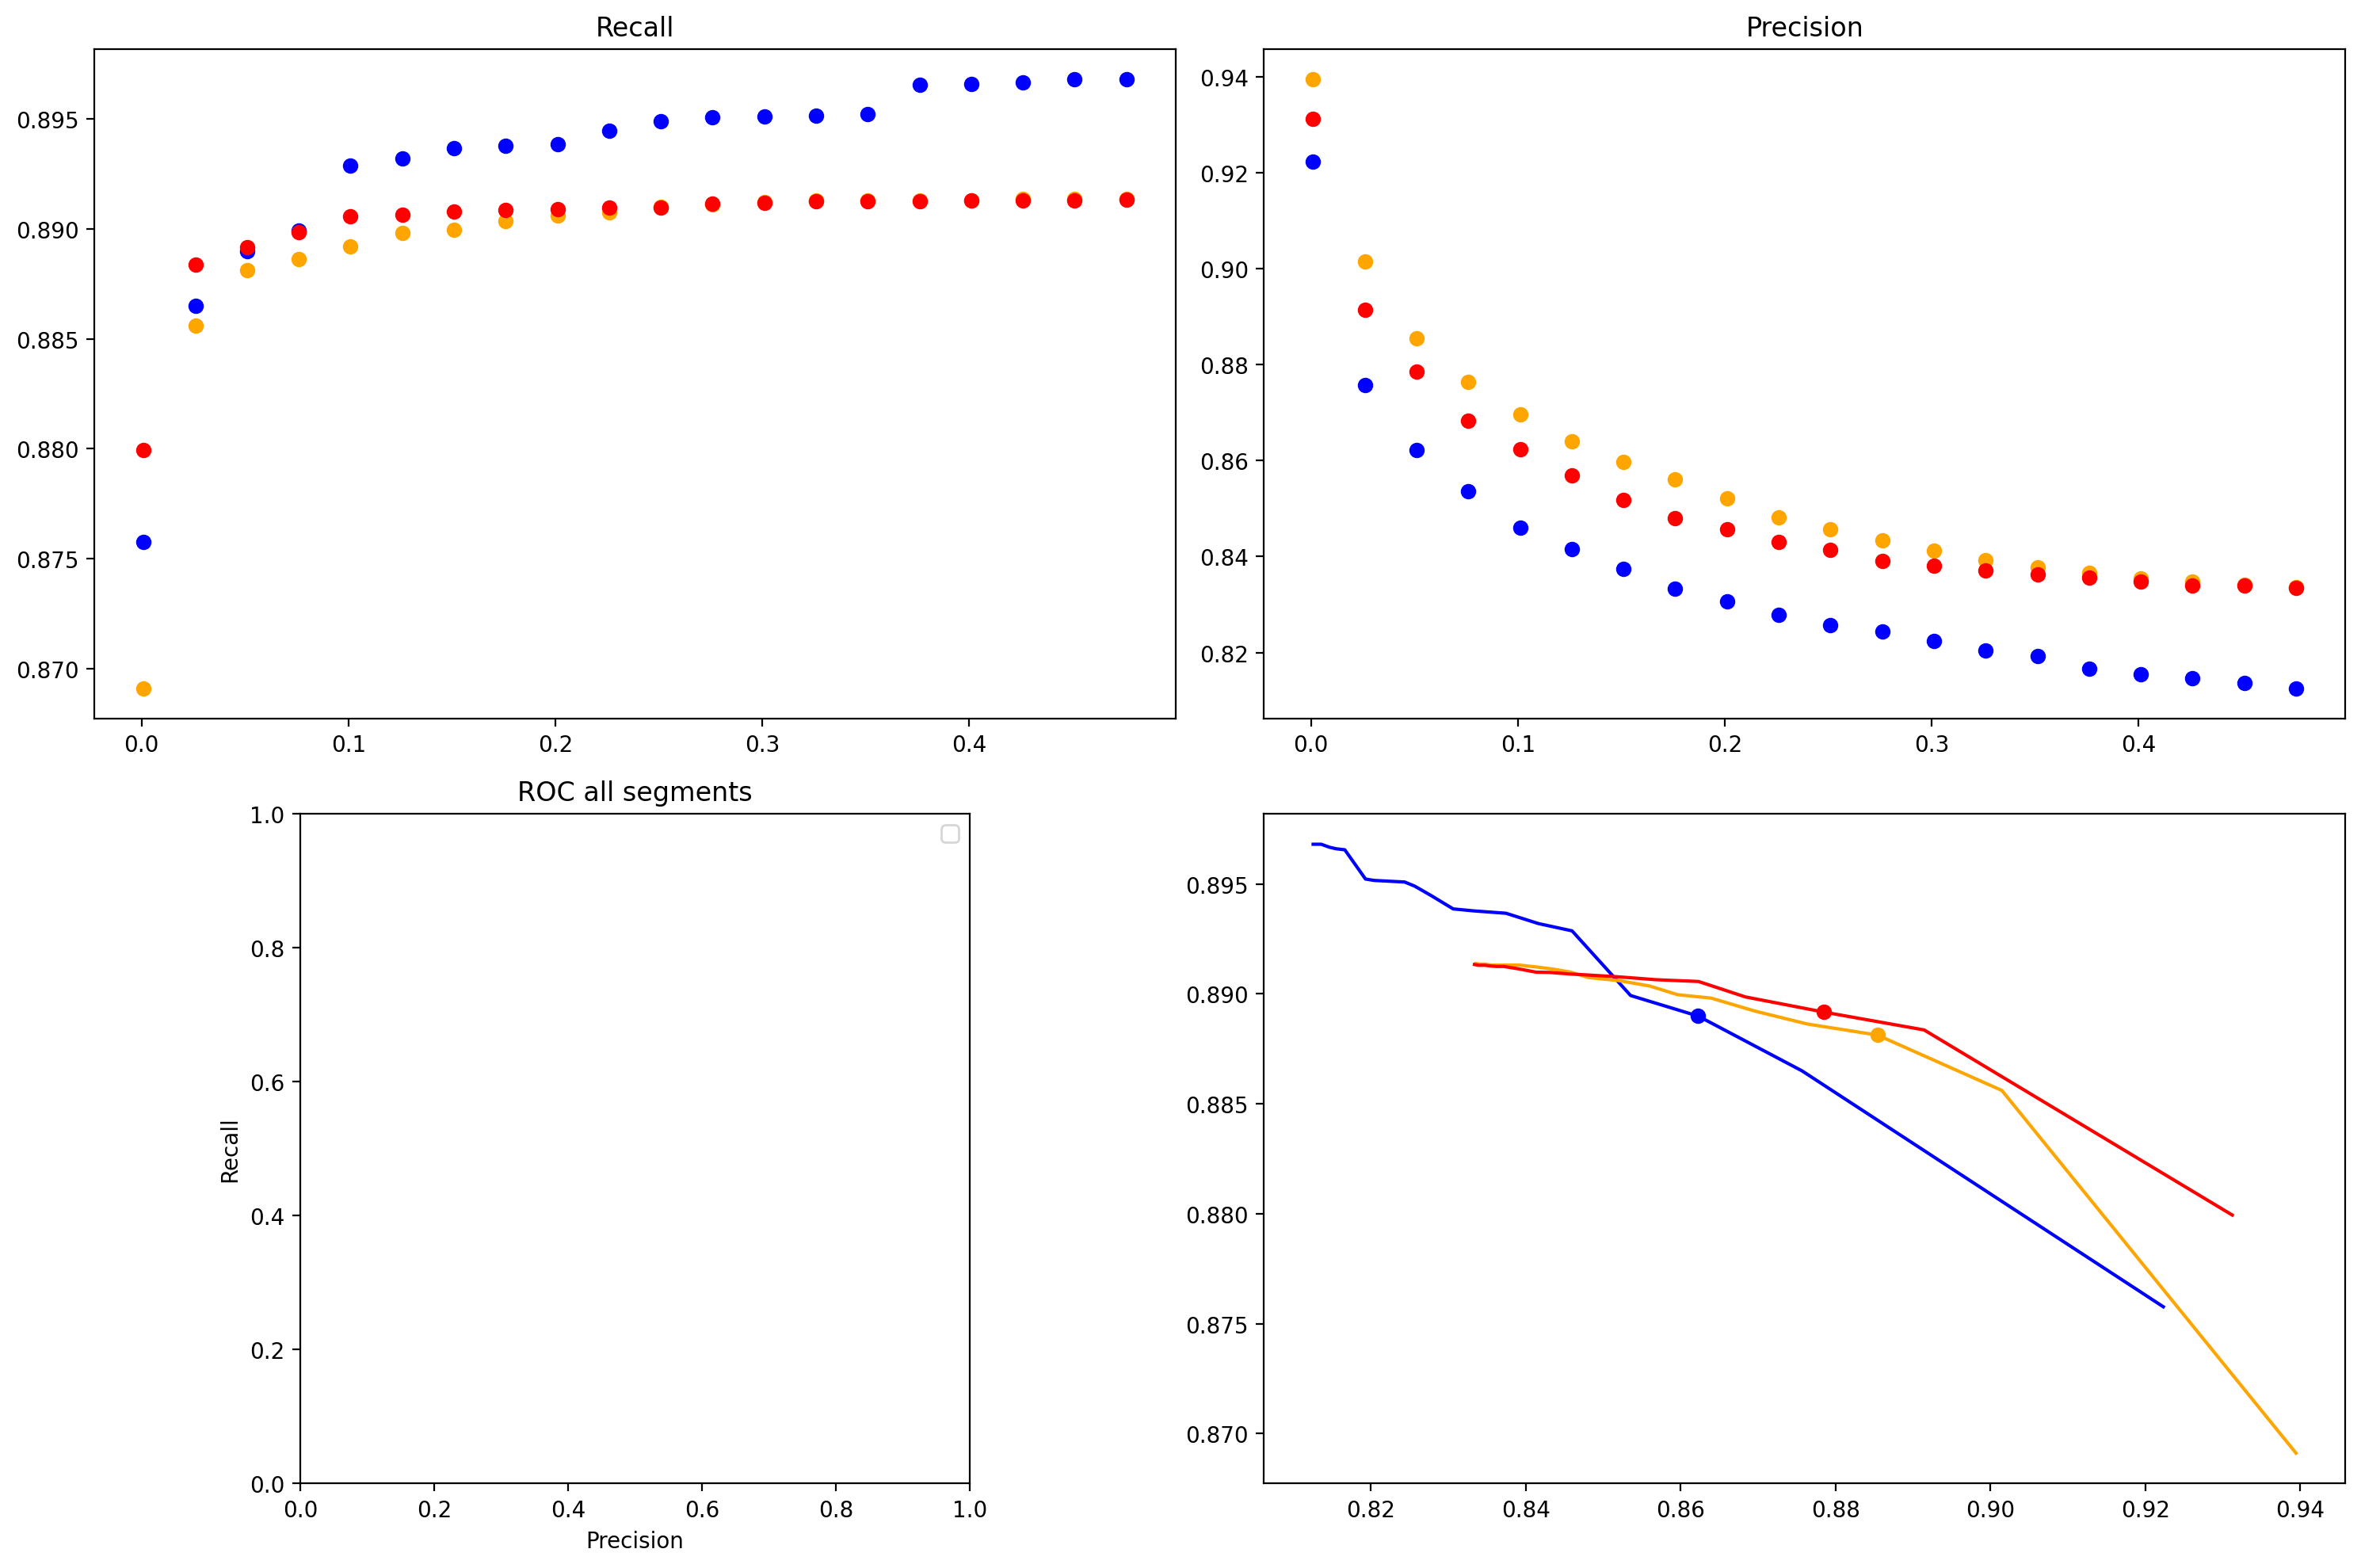

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


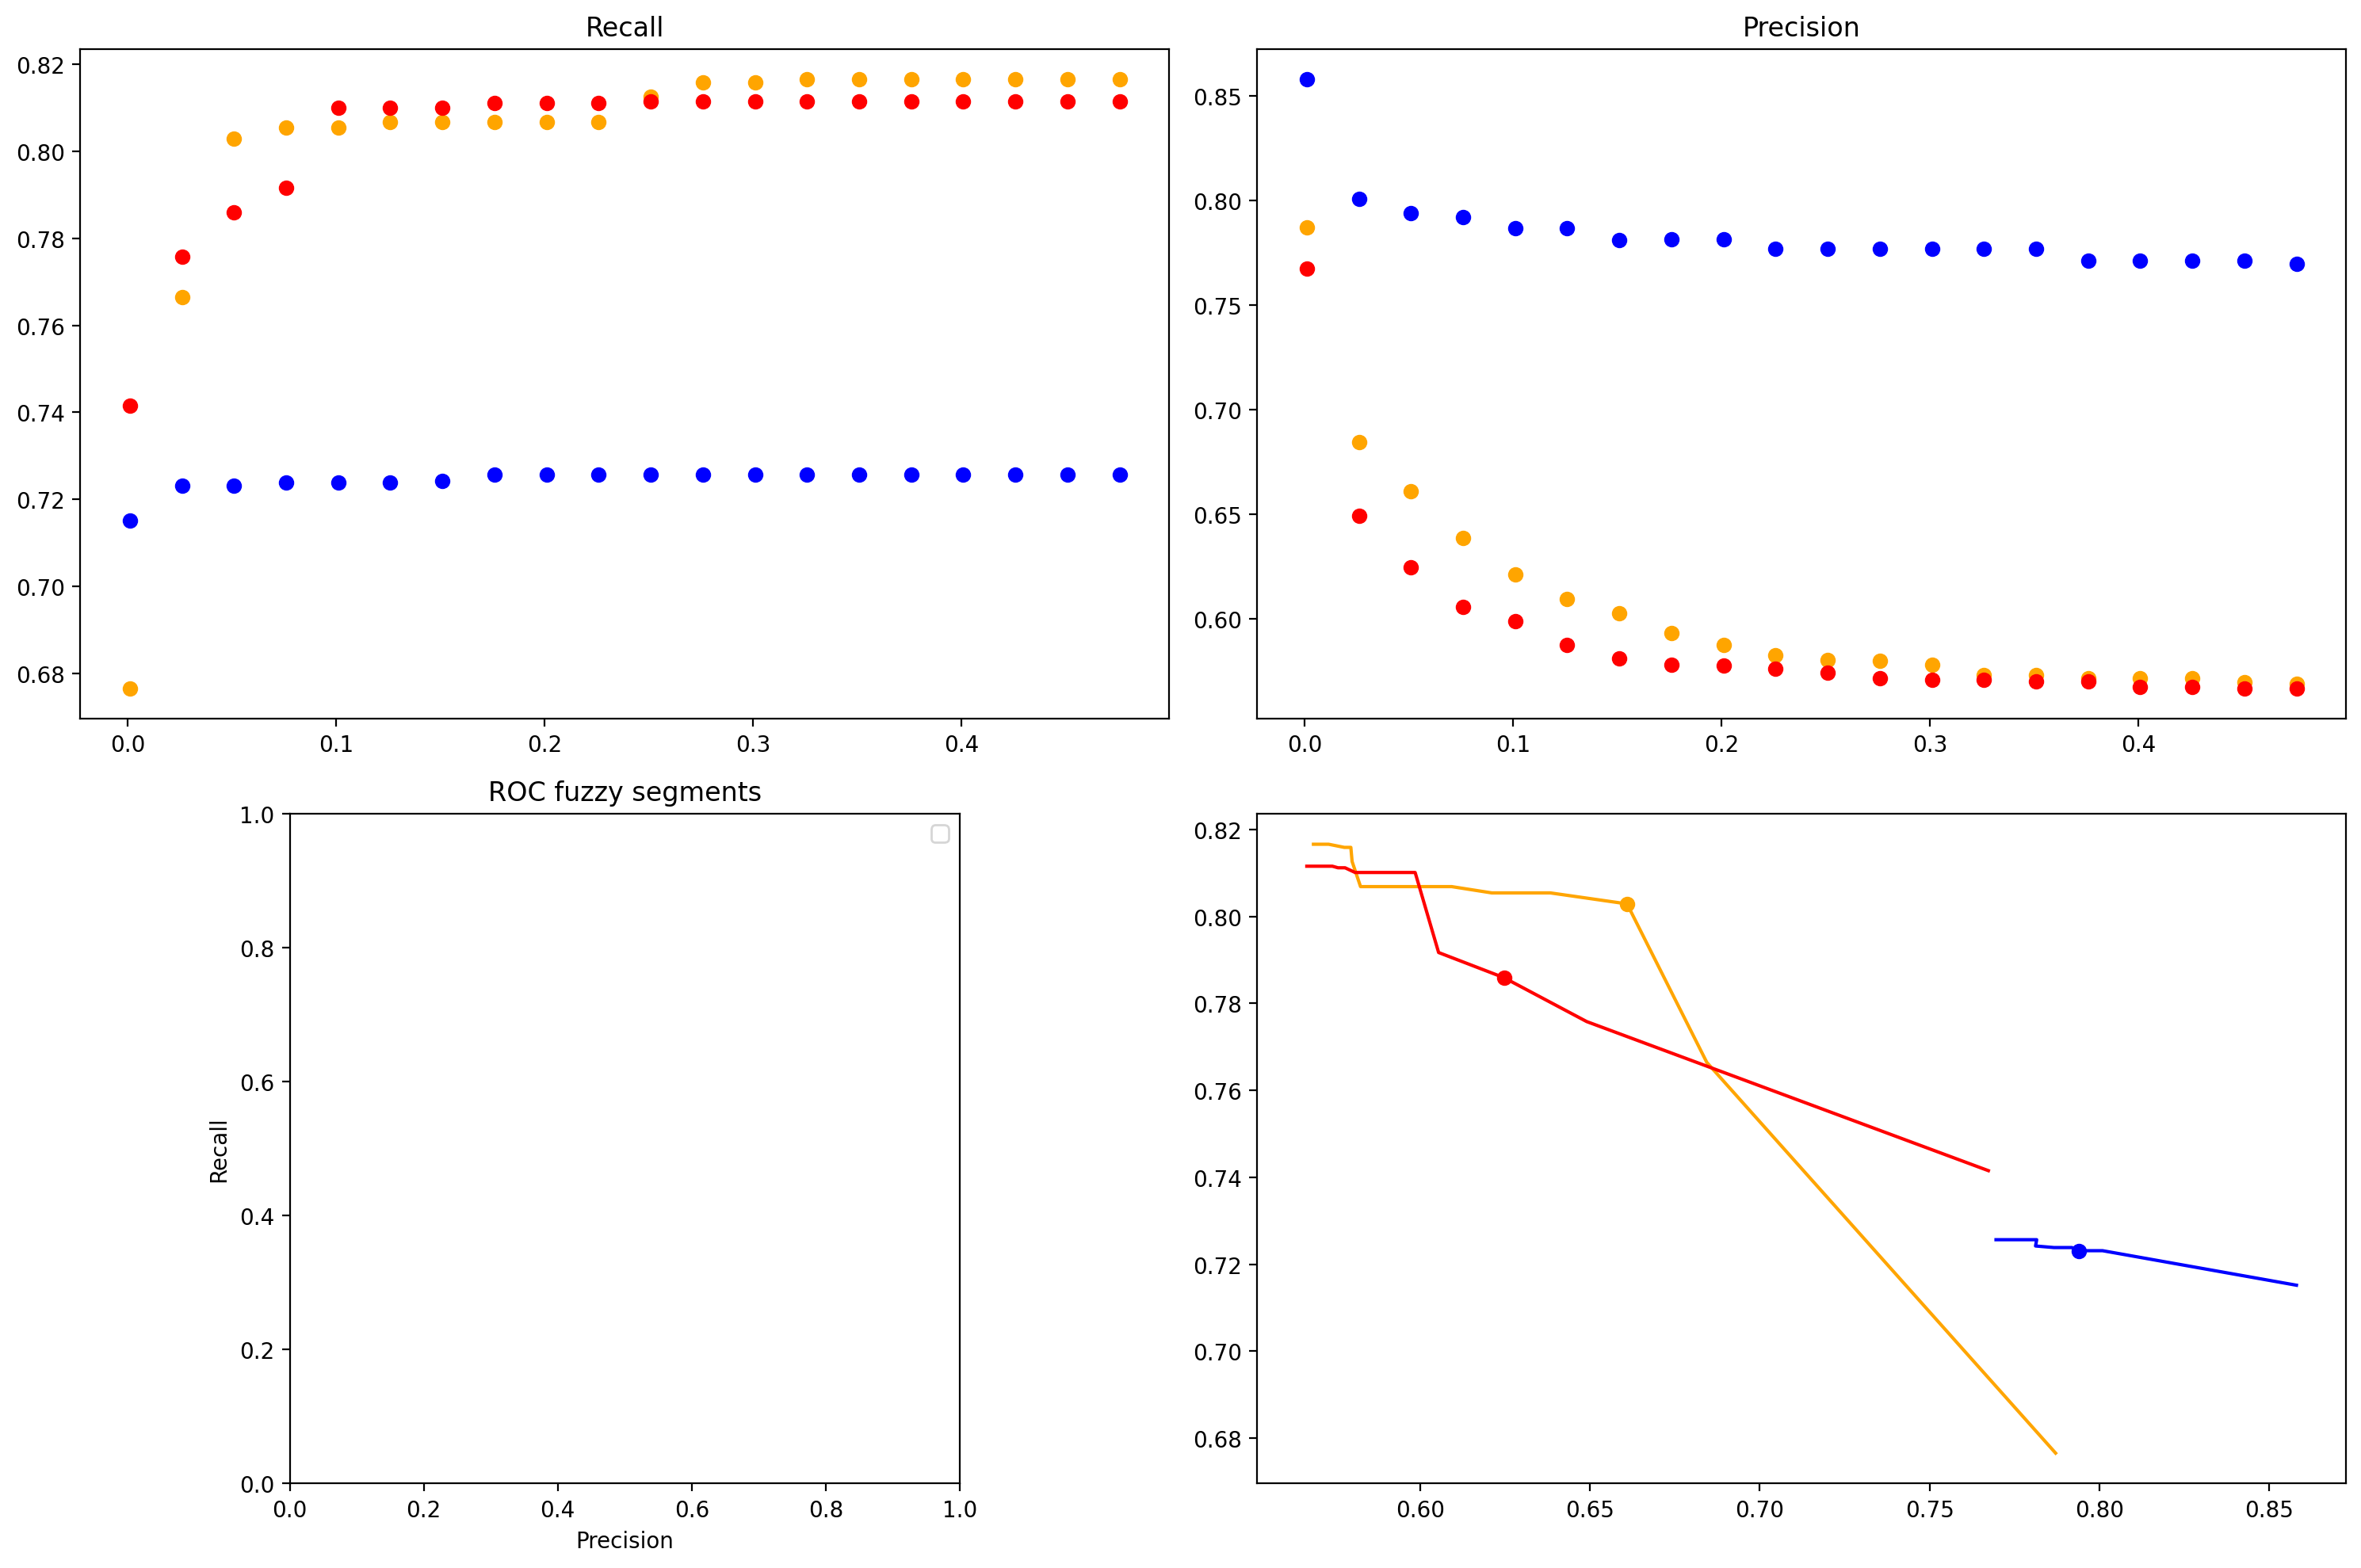

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


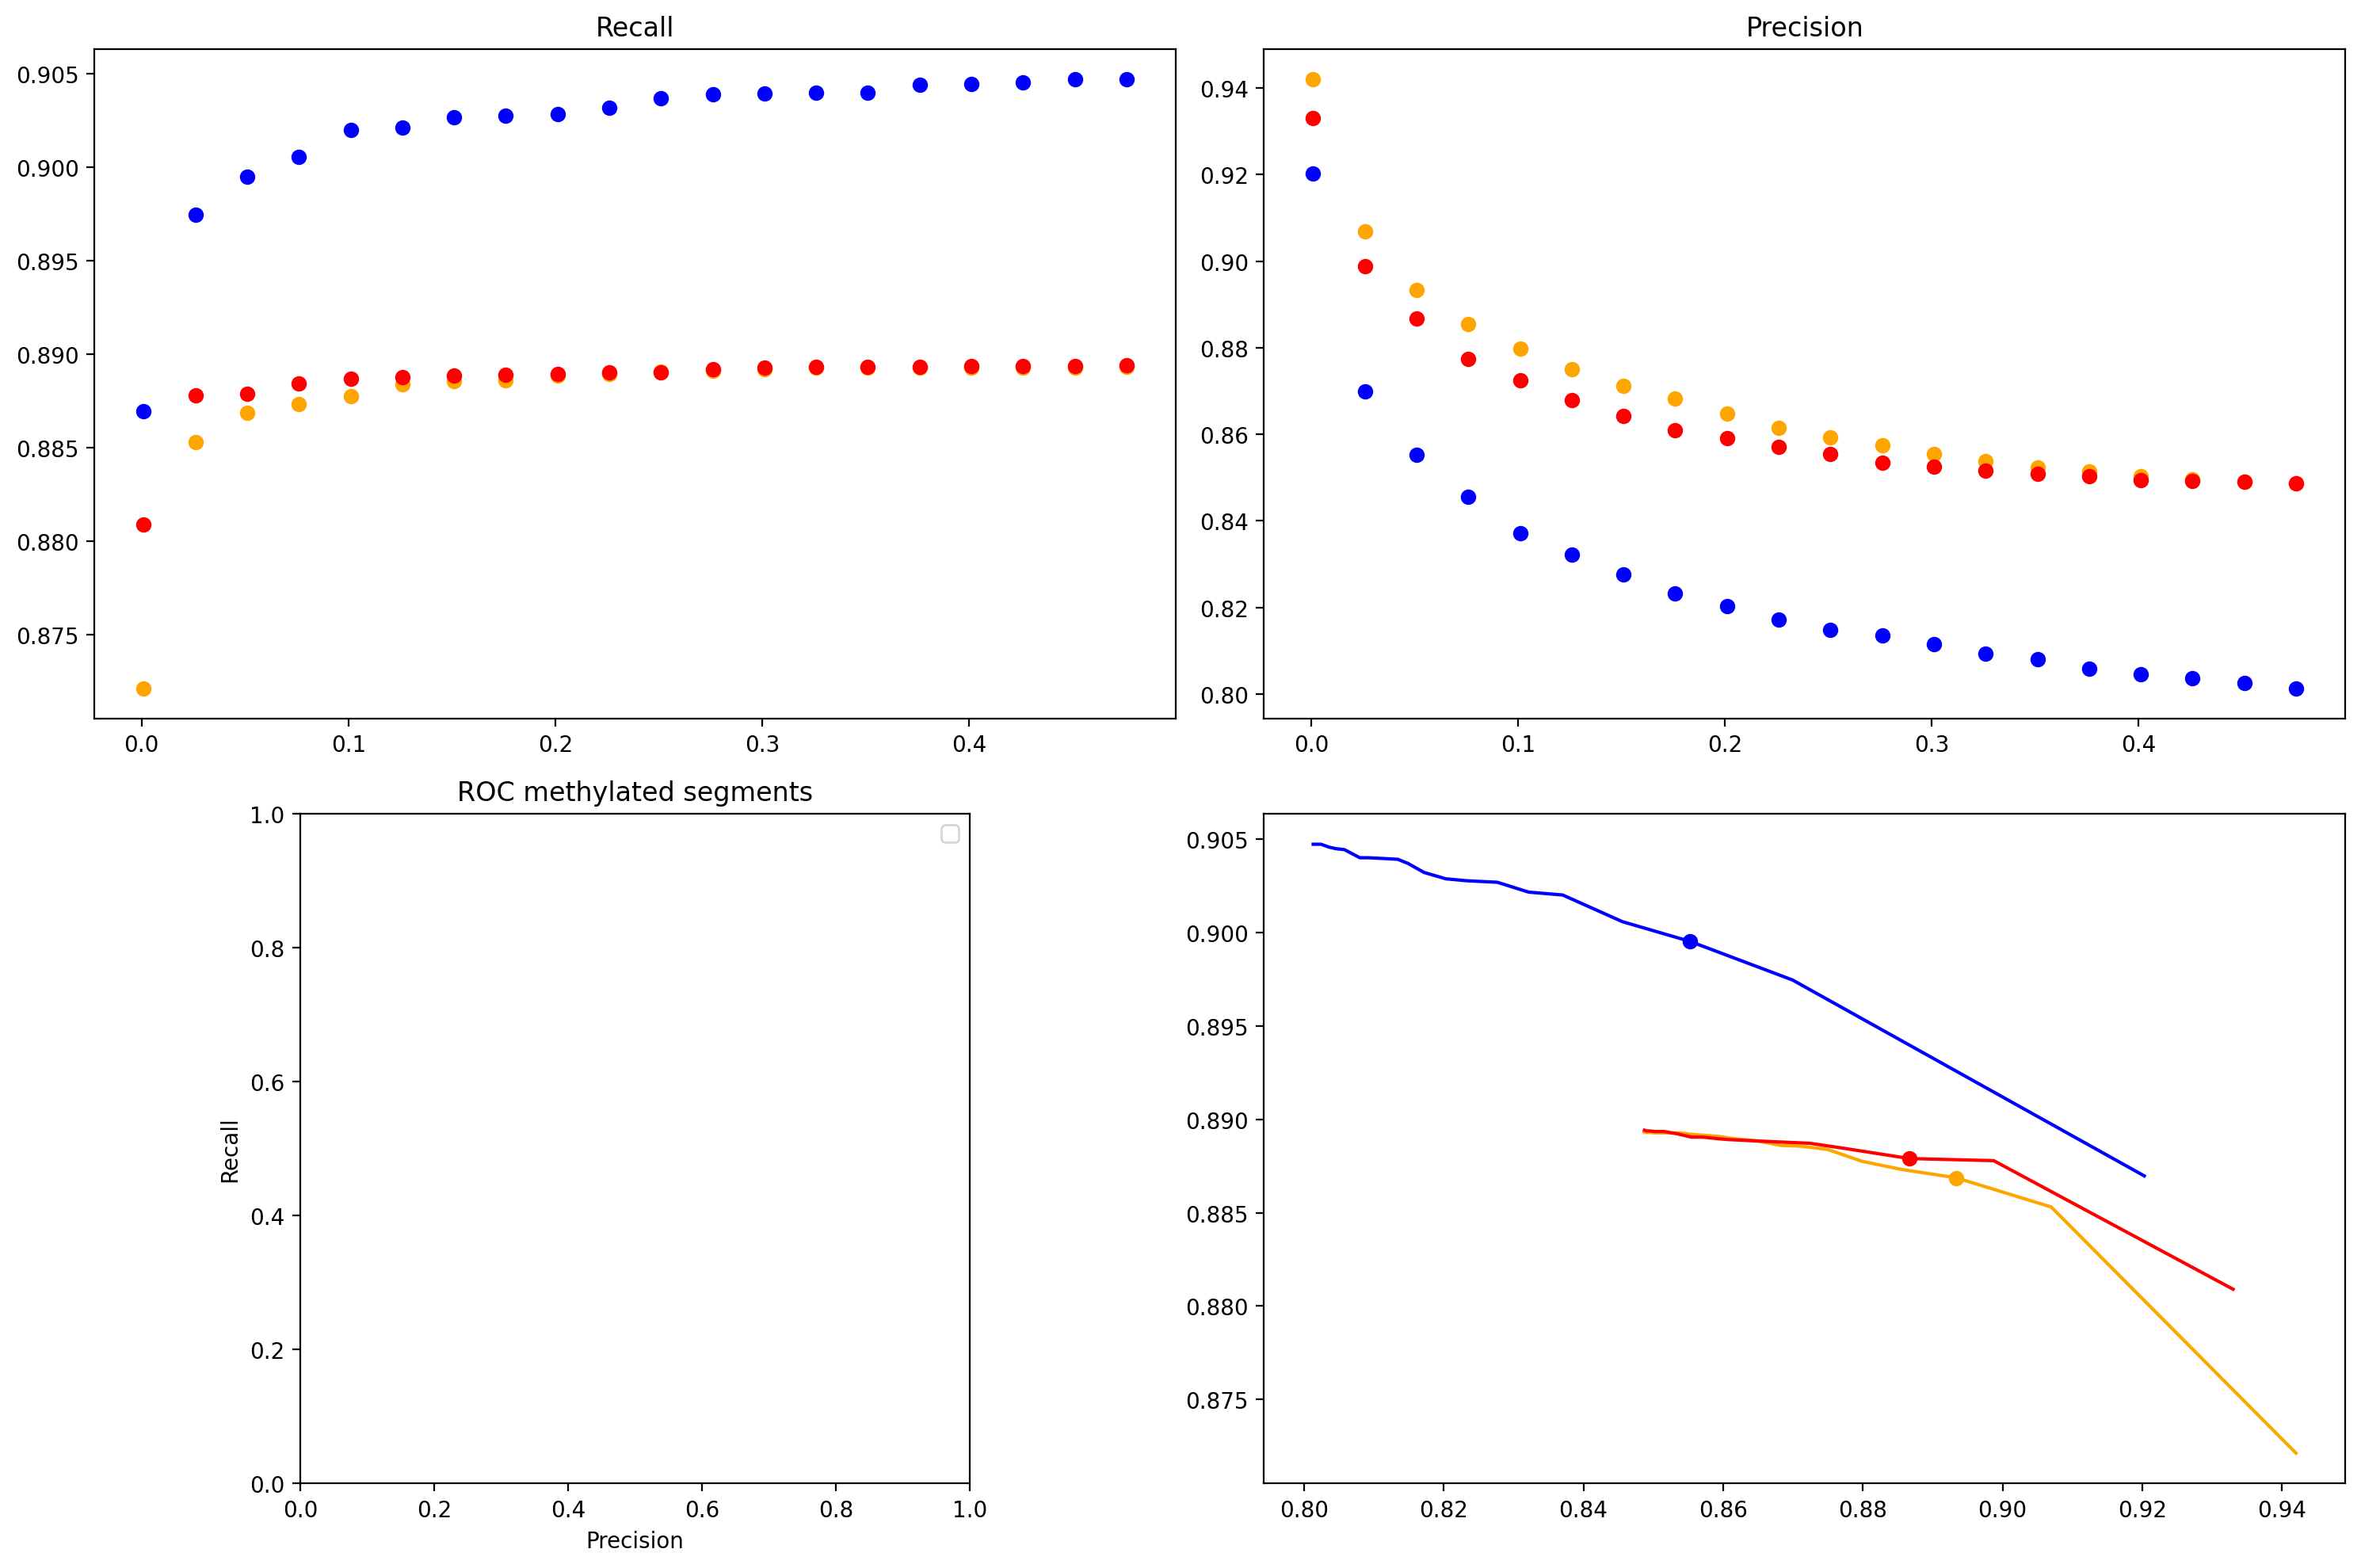

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


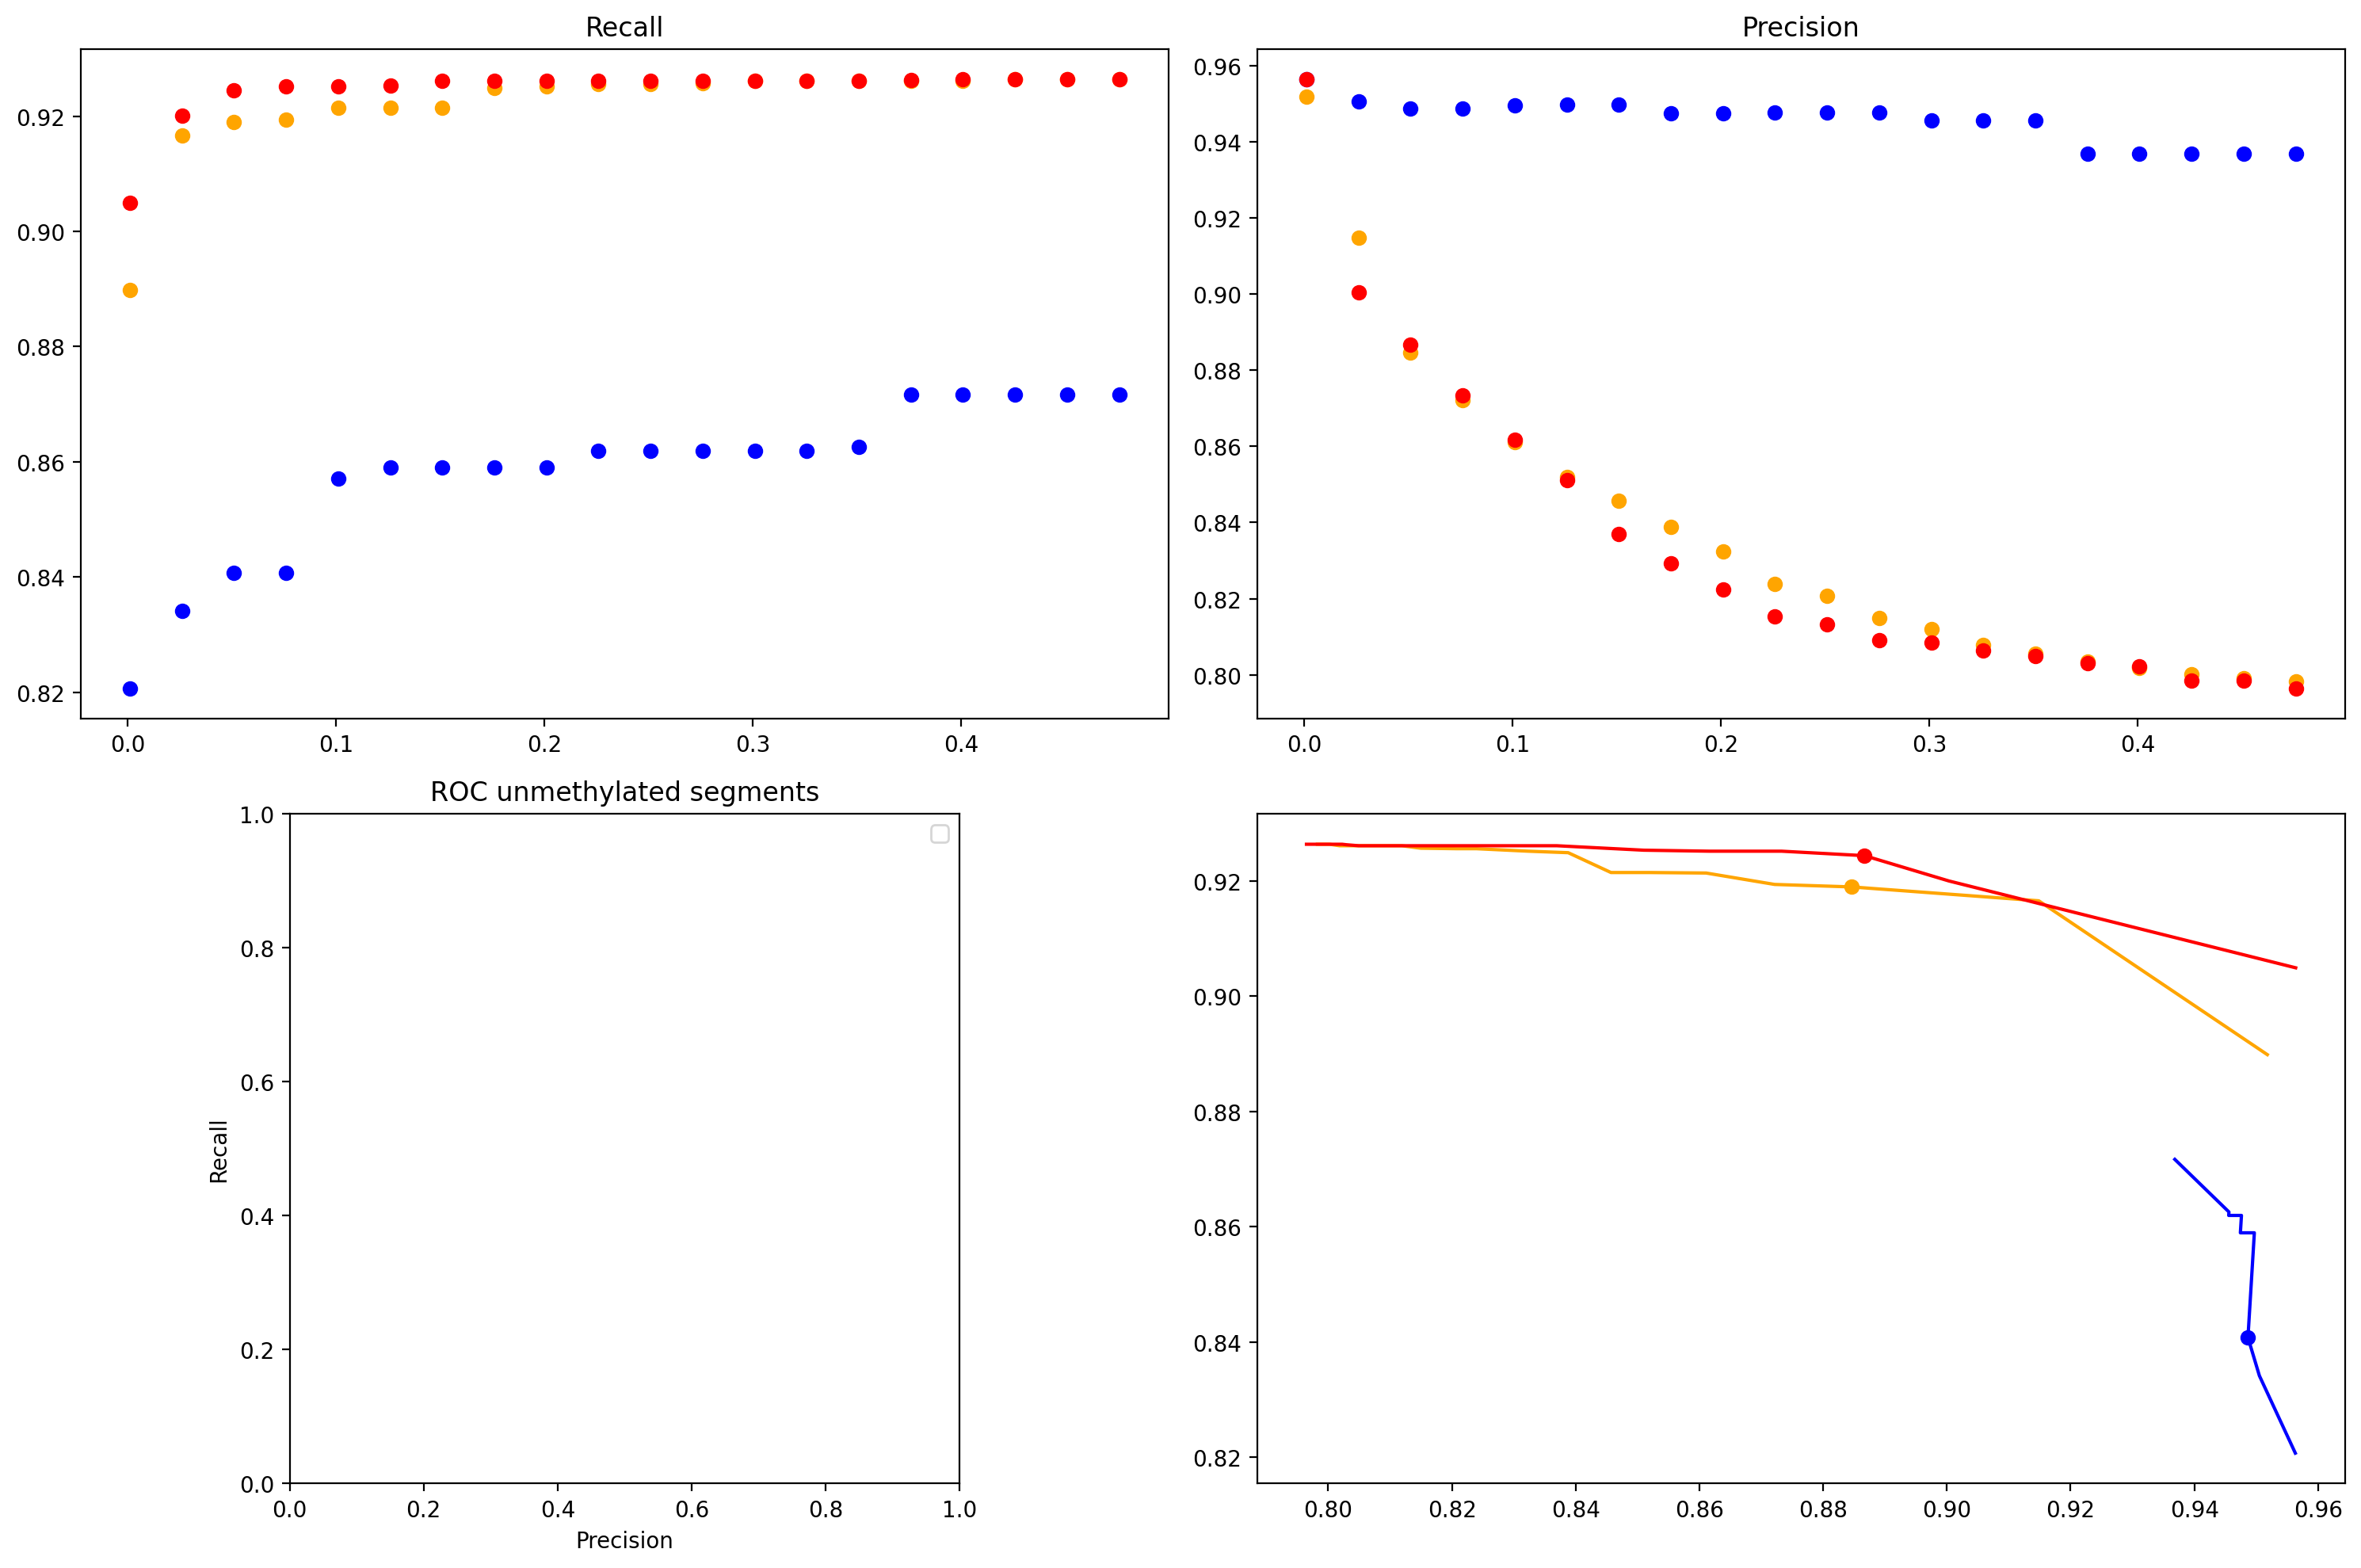

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


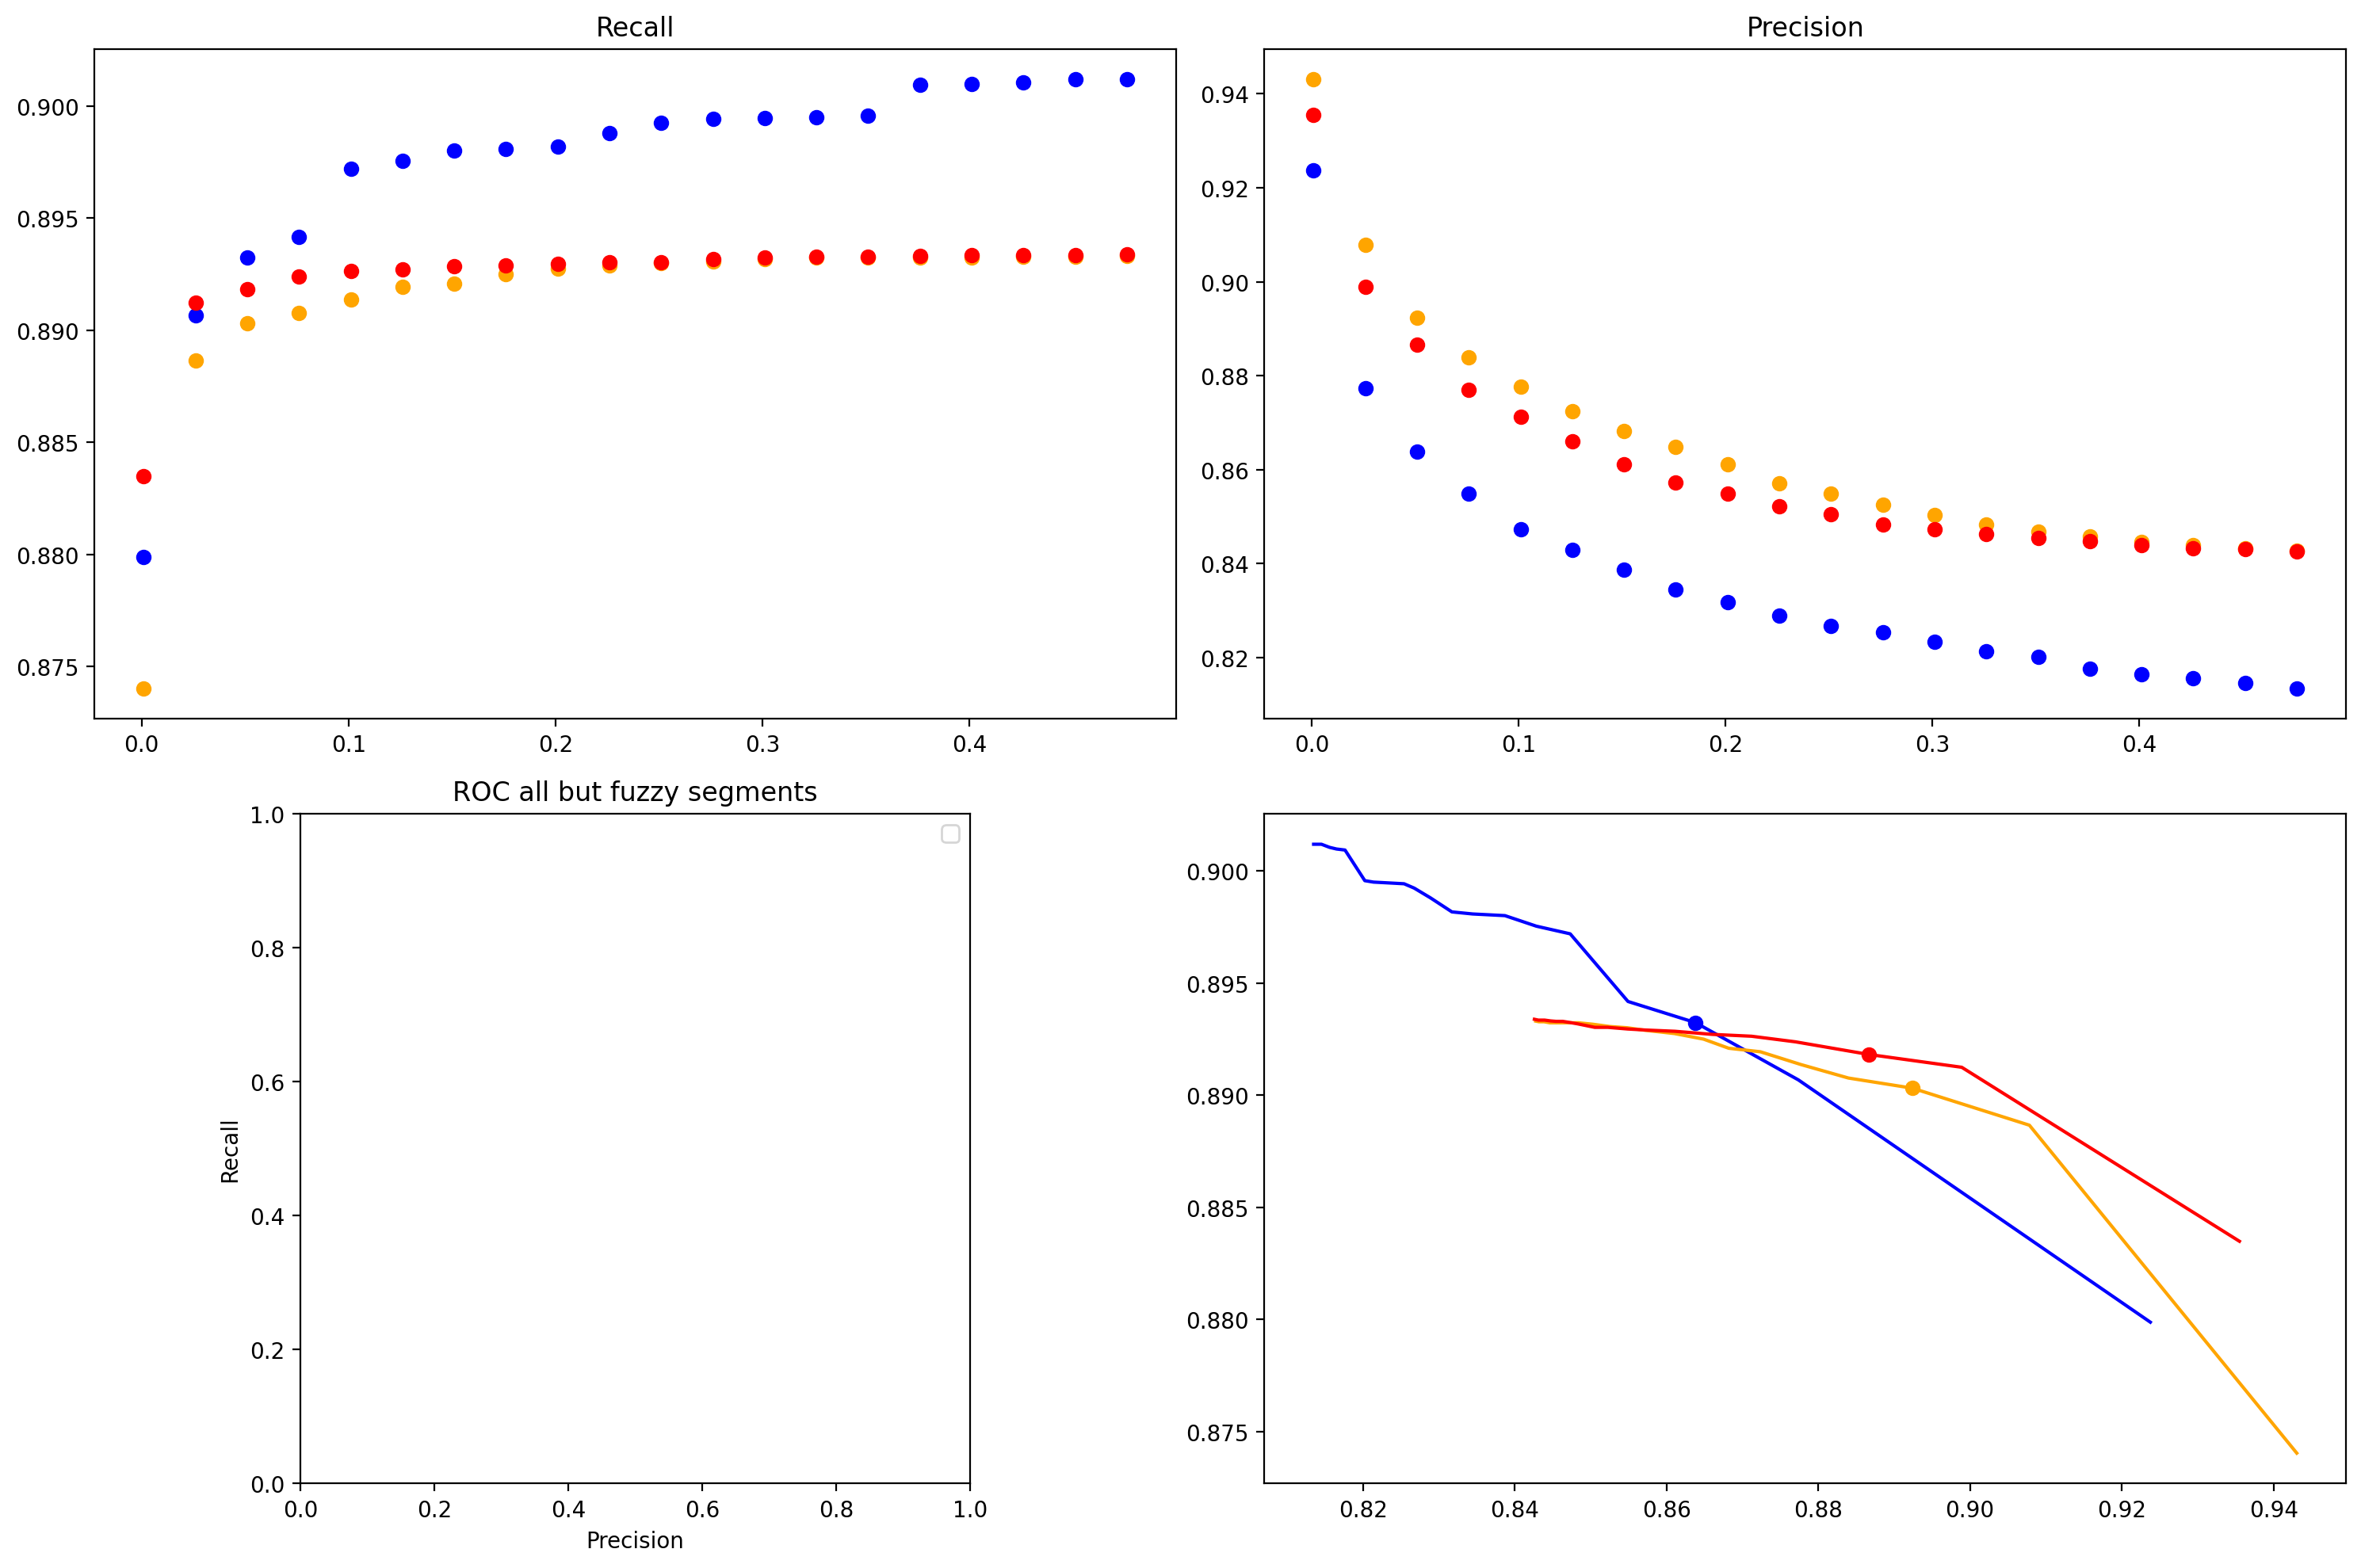

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


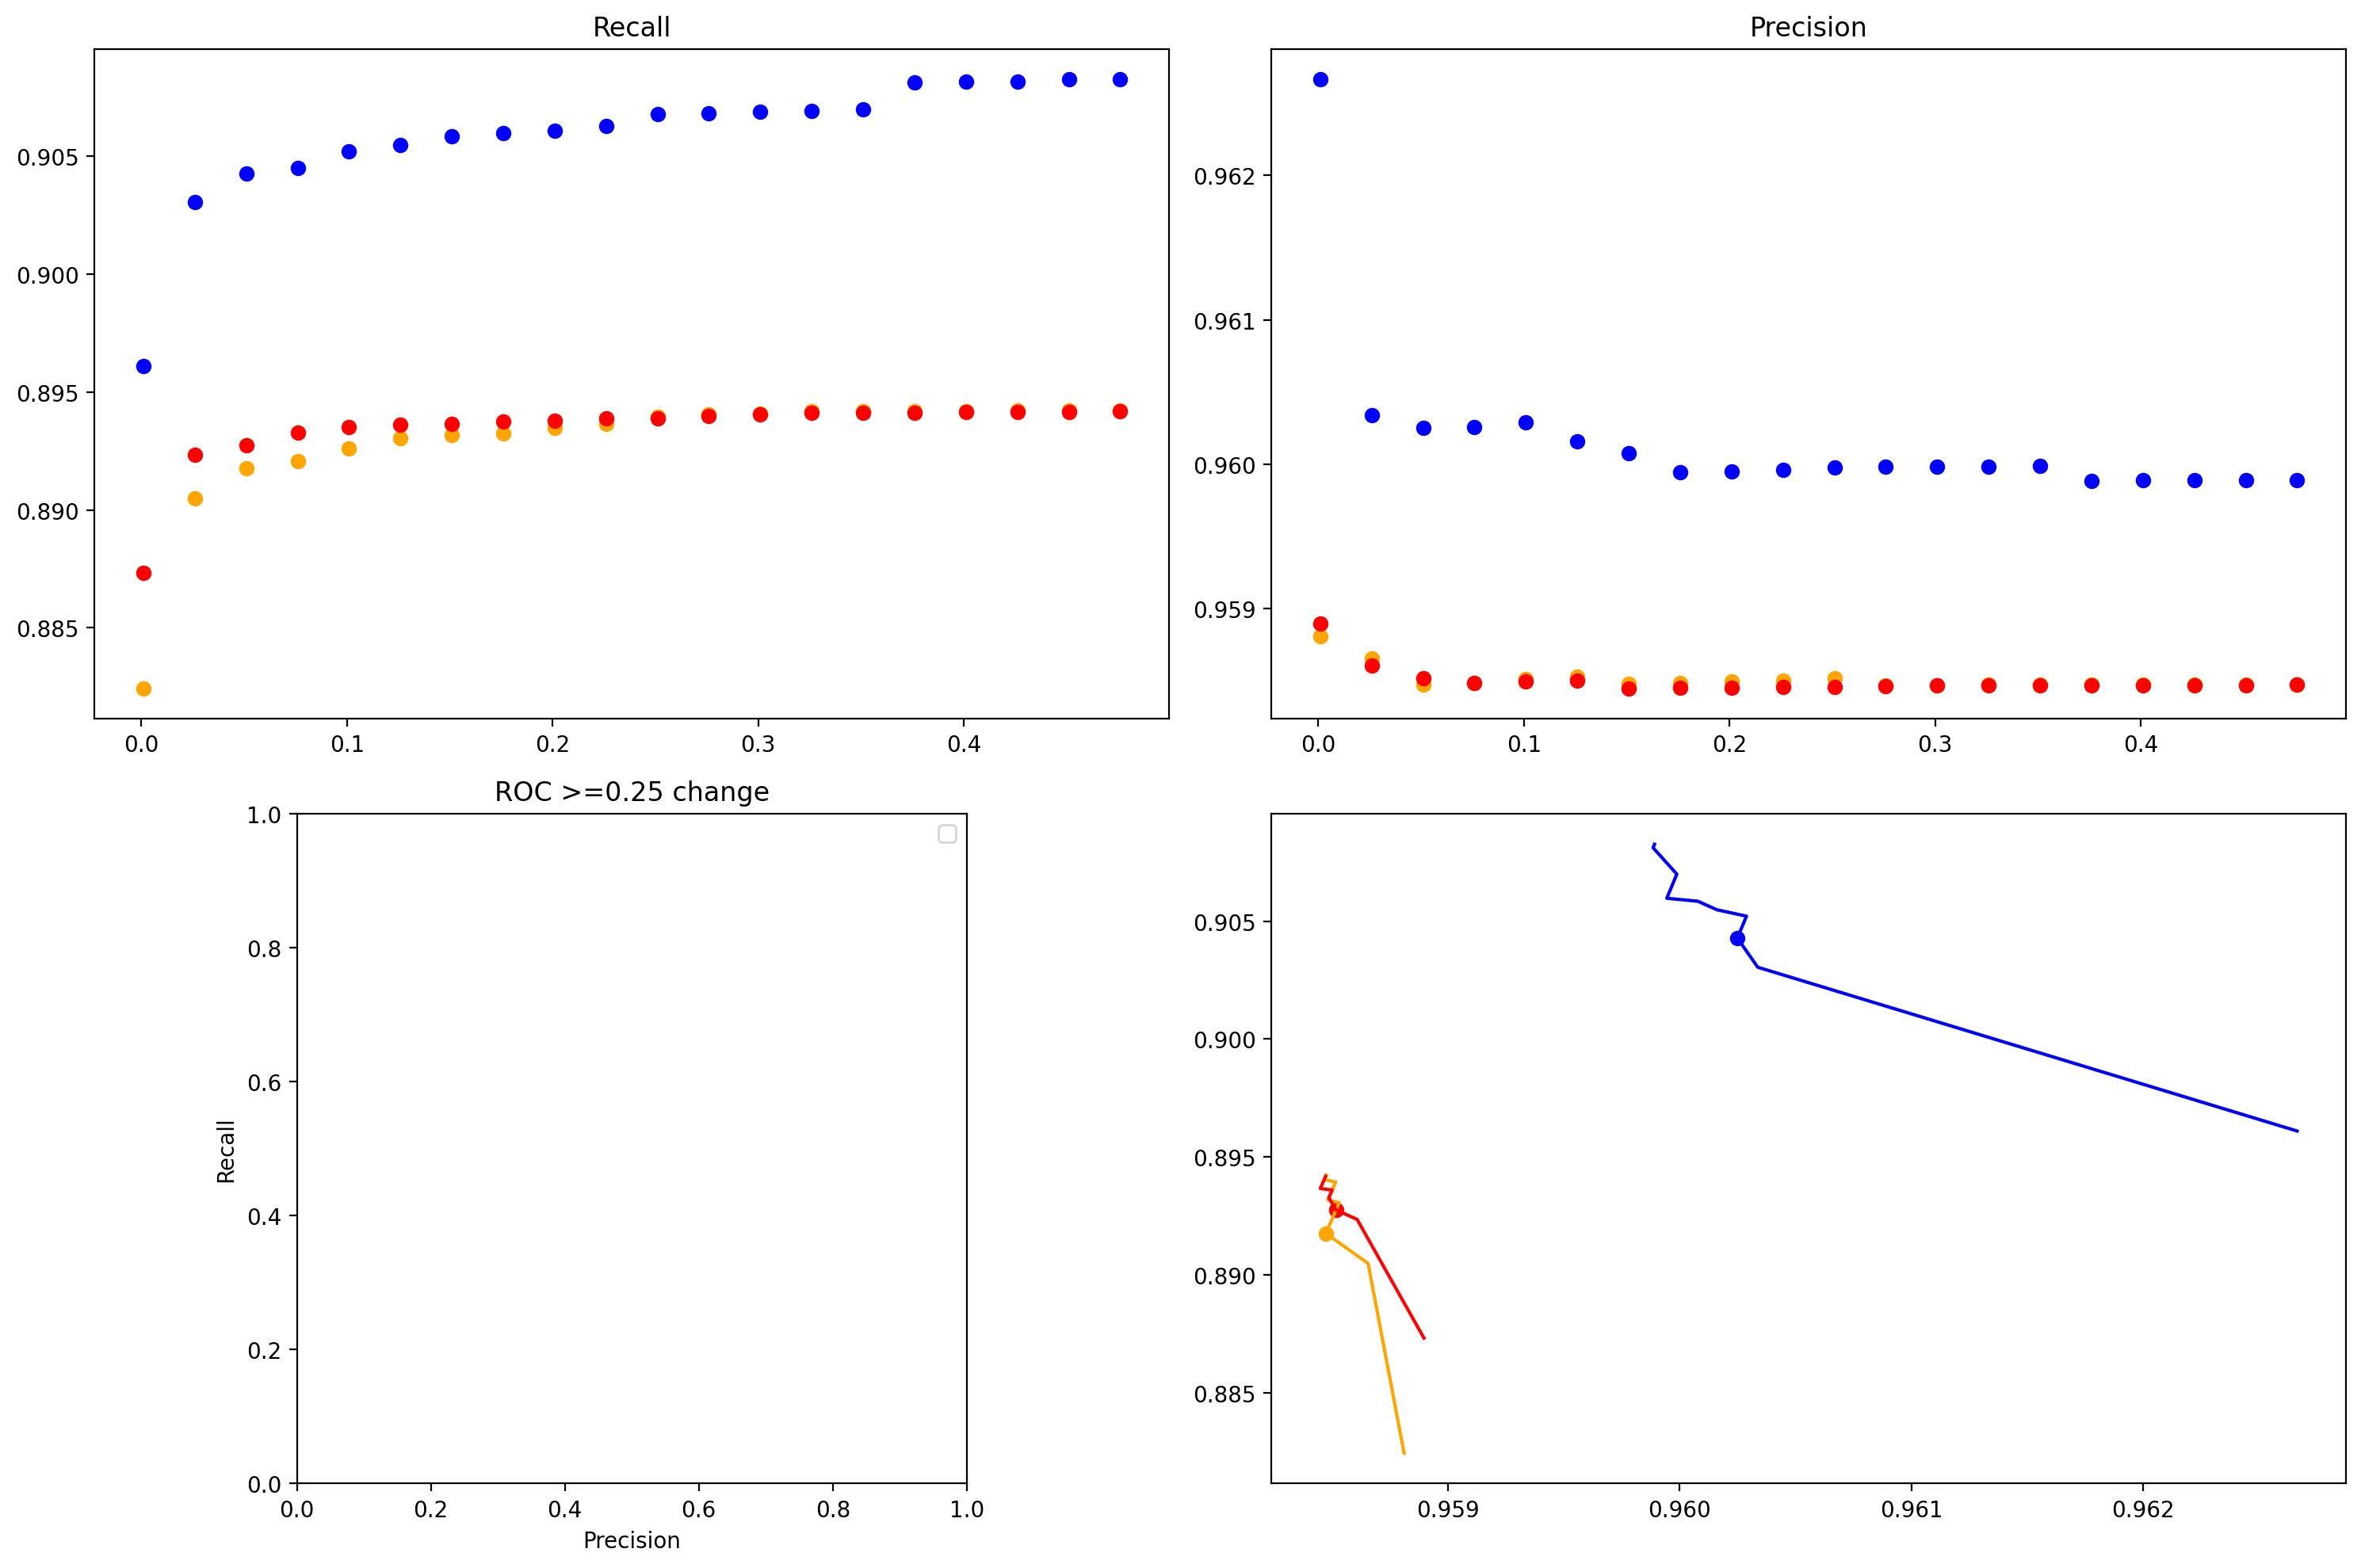

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


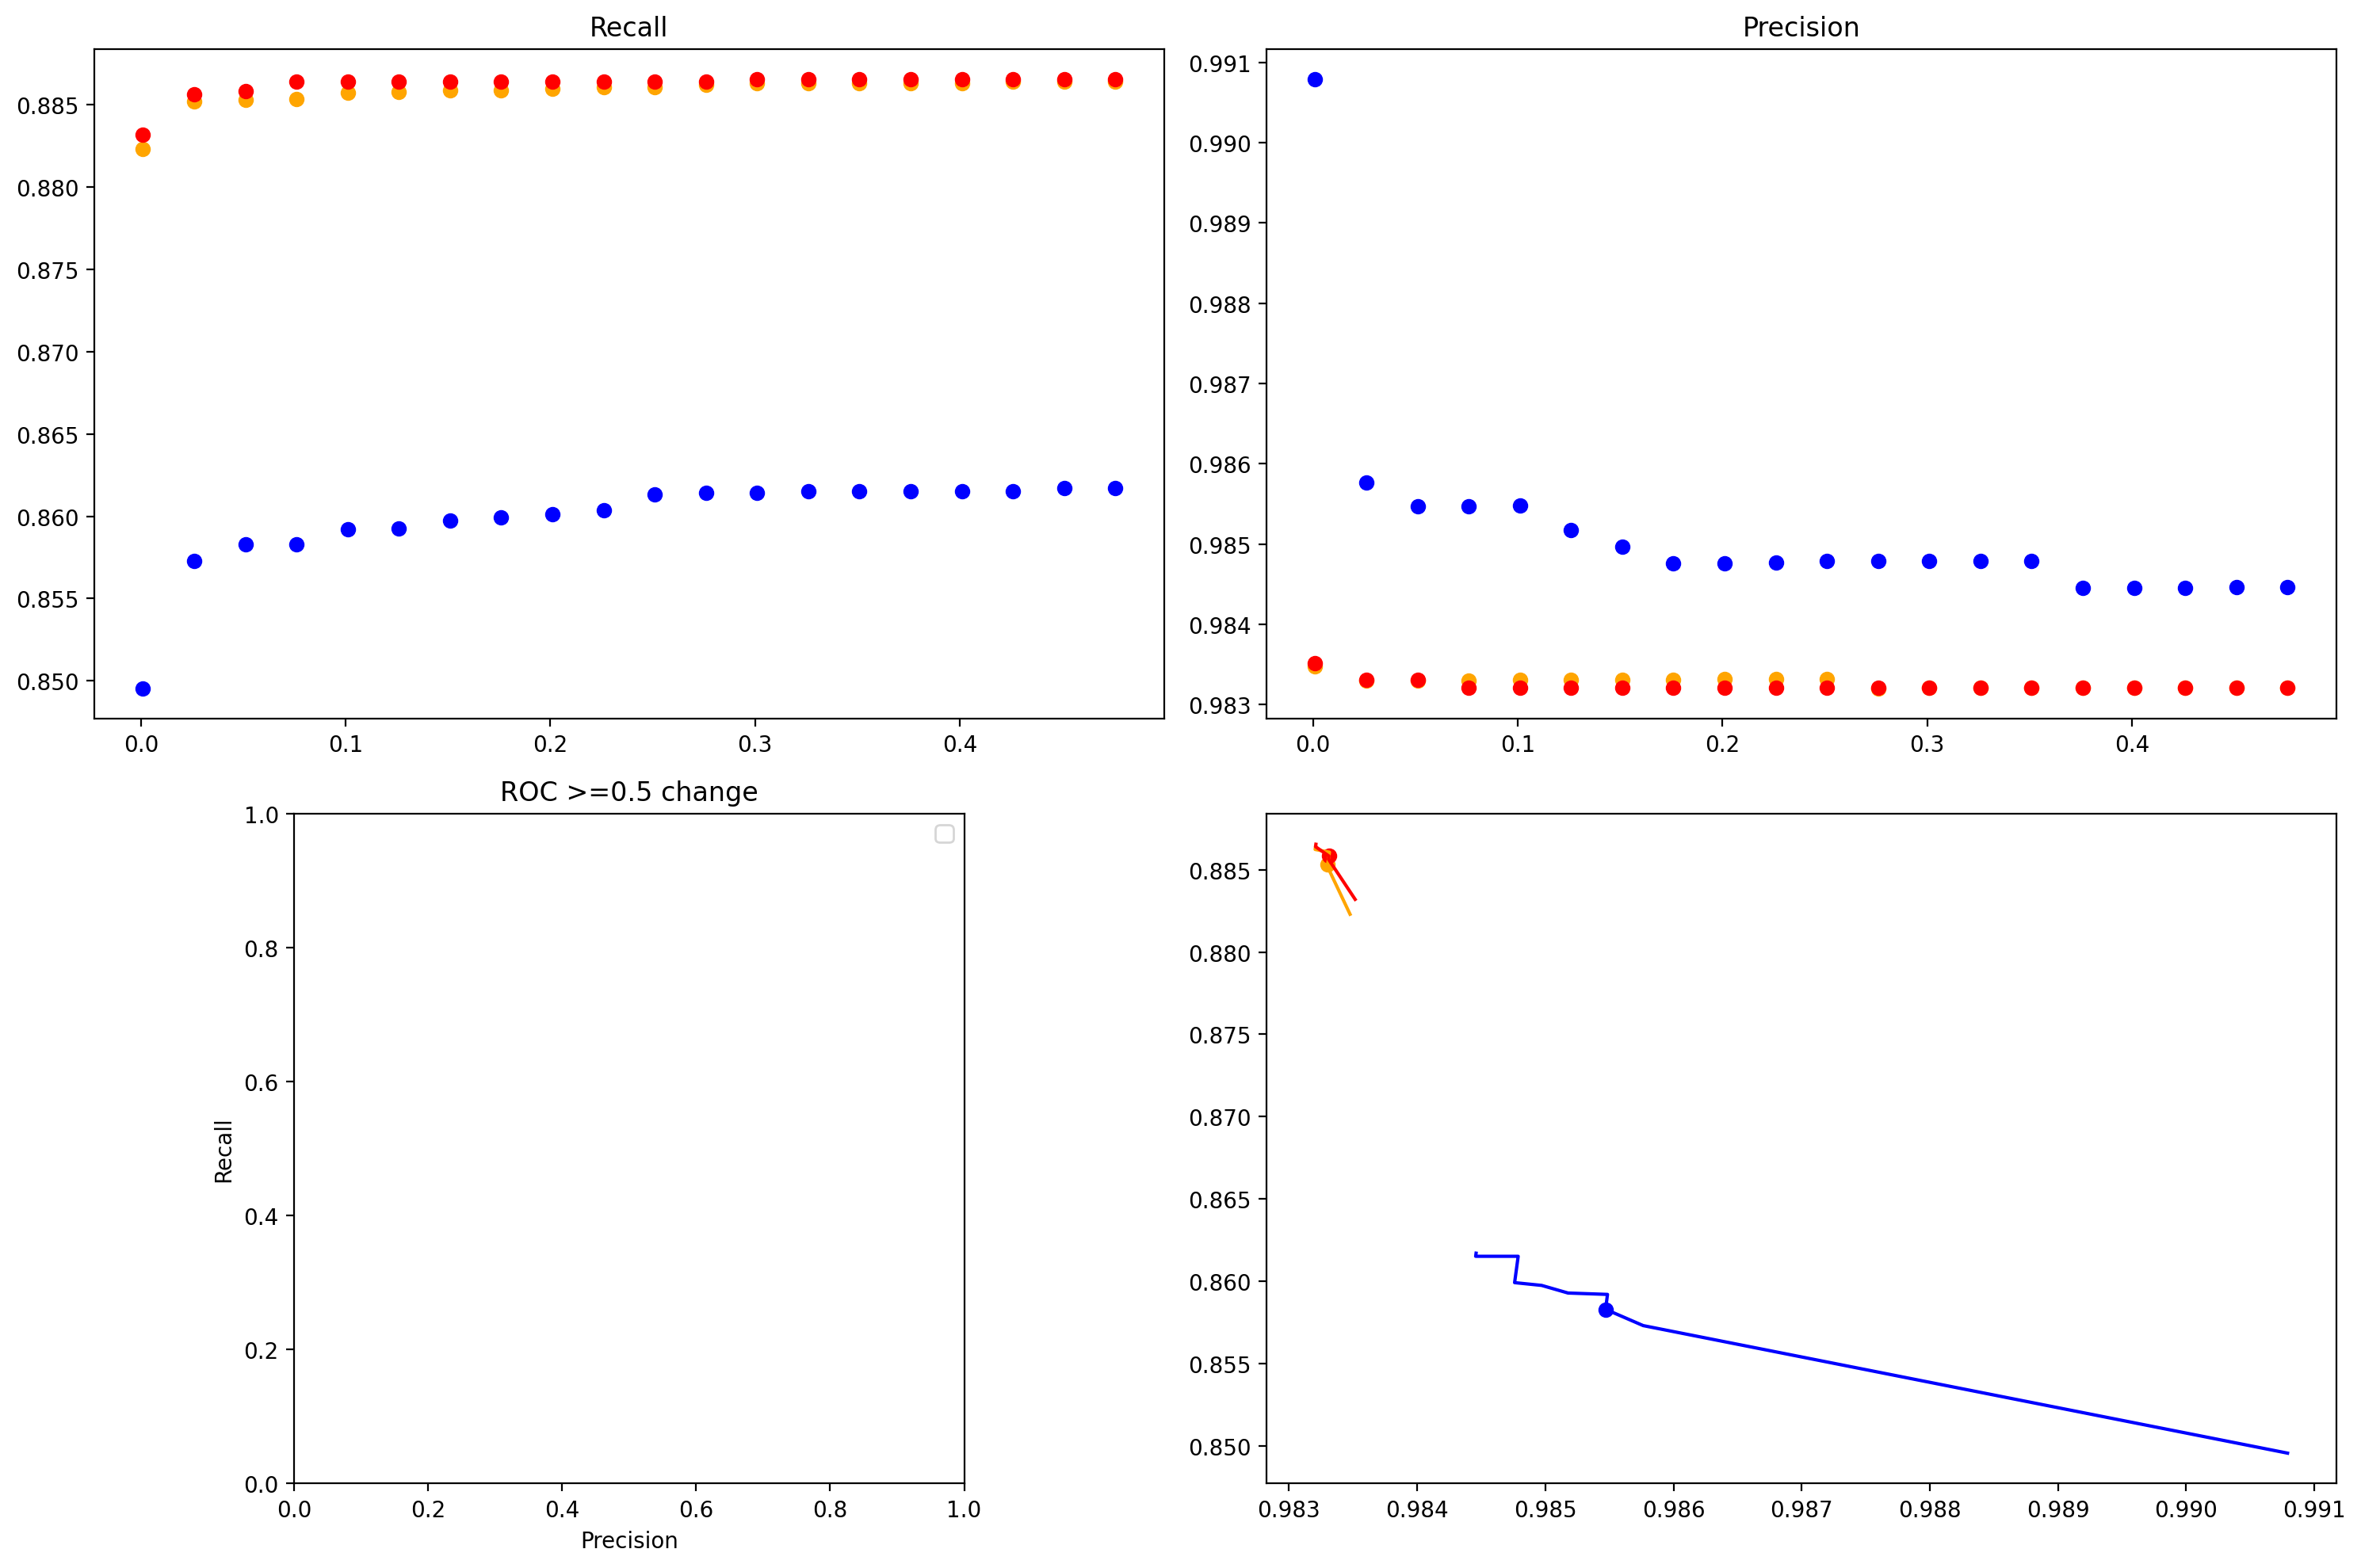

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


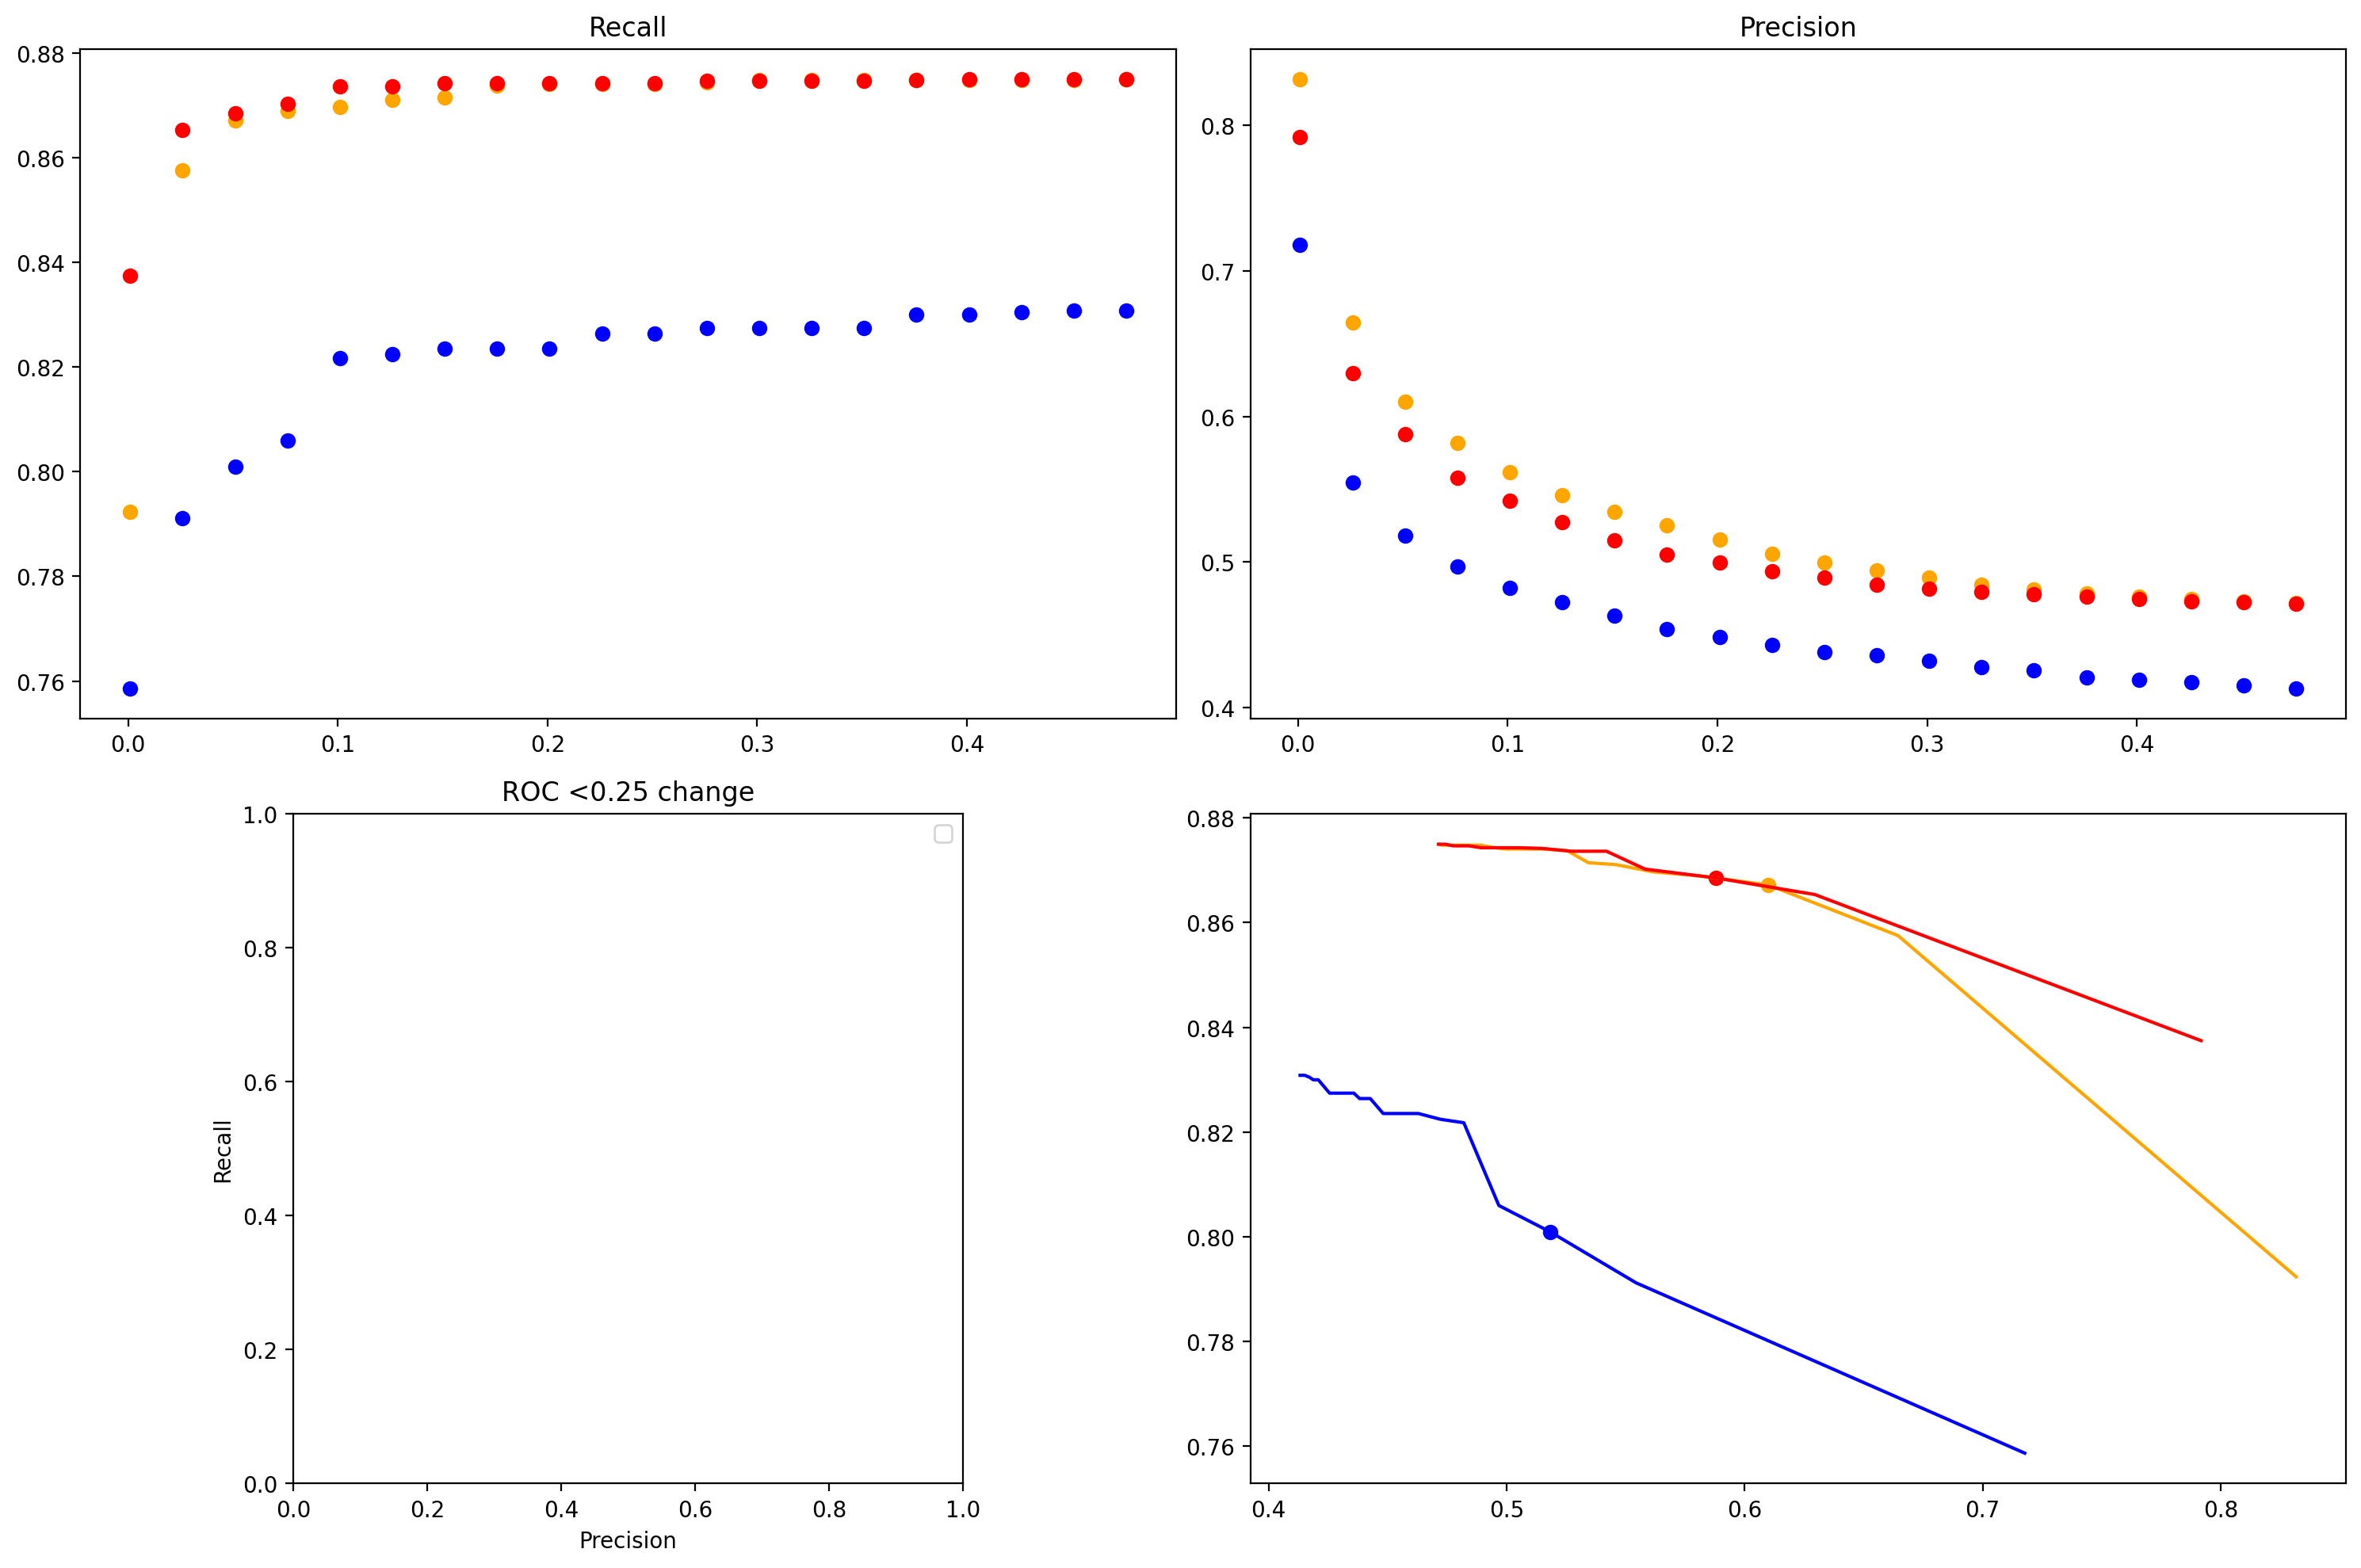

In [176]:
plot_roc(gt, "ROC all segments", "roc_all")
plot_roc(gt.loc[gt["segment_type"]==3].copy(), "ROC fuzzy segments", "roc_fuzzy")
plot_roc(gt.loc[gt["segment_type"]==2].copy(), "ROC methylated segments", "roc_methylated")
plot_roc(gt.loc[gt["segment_type"]==1].copy(), "ROC unmethylated segments", "roc_unmethylated")
plot_roc(gt.loc[gt["segment_type"]!=3].copy(), "ROC all but fuzzy segments", "roc_notfuzzy")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), "ROC >=0.25 change", "roc_effect_size_ge0.25")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), "ROC >=0.5 change", "roc_effect_size_ge0.5")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "ROC <0.25 change", "roc_effect_size_lt0.5")

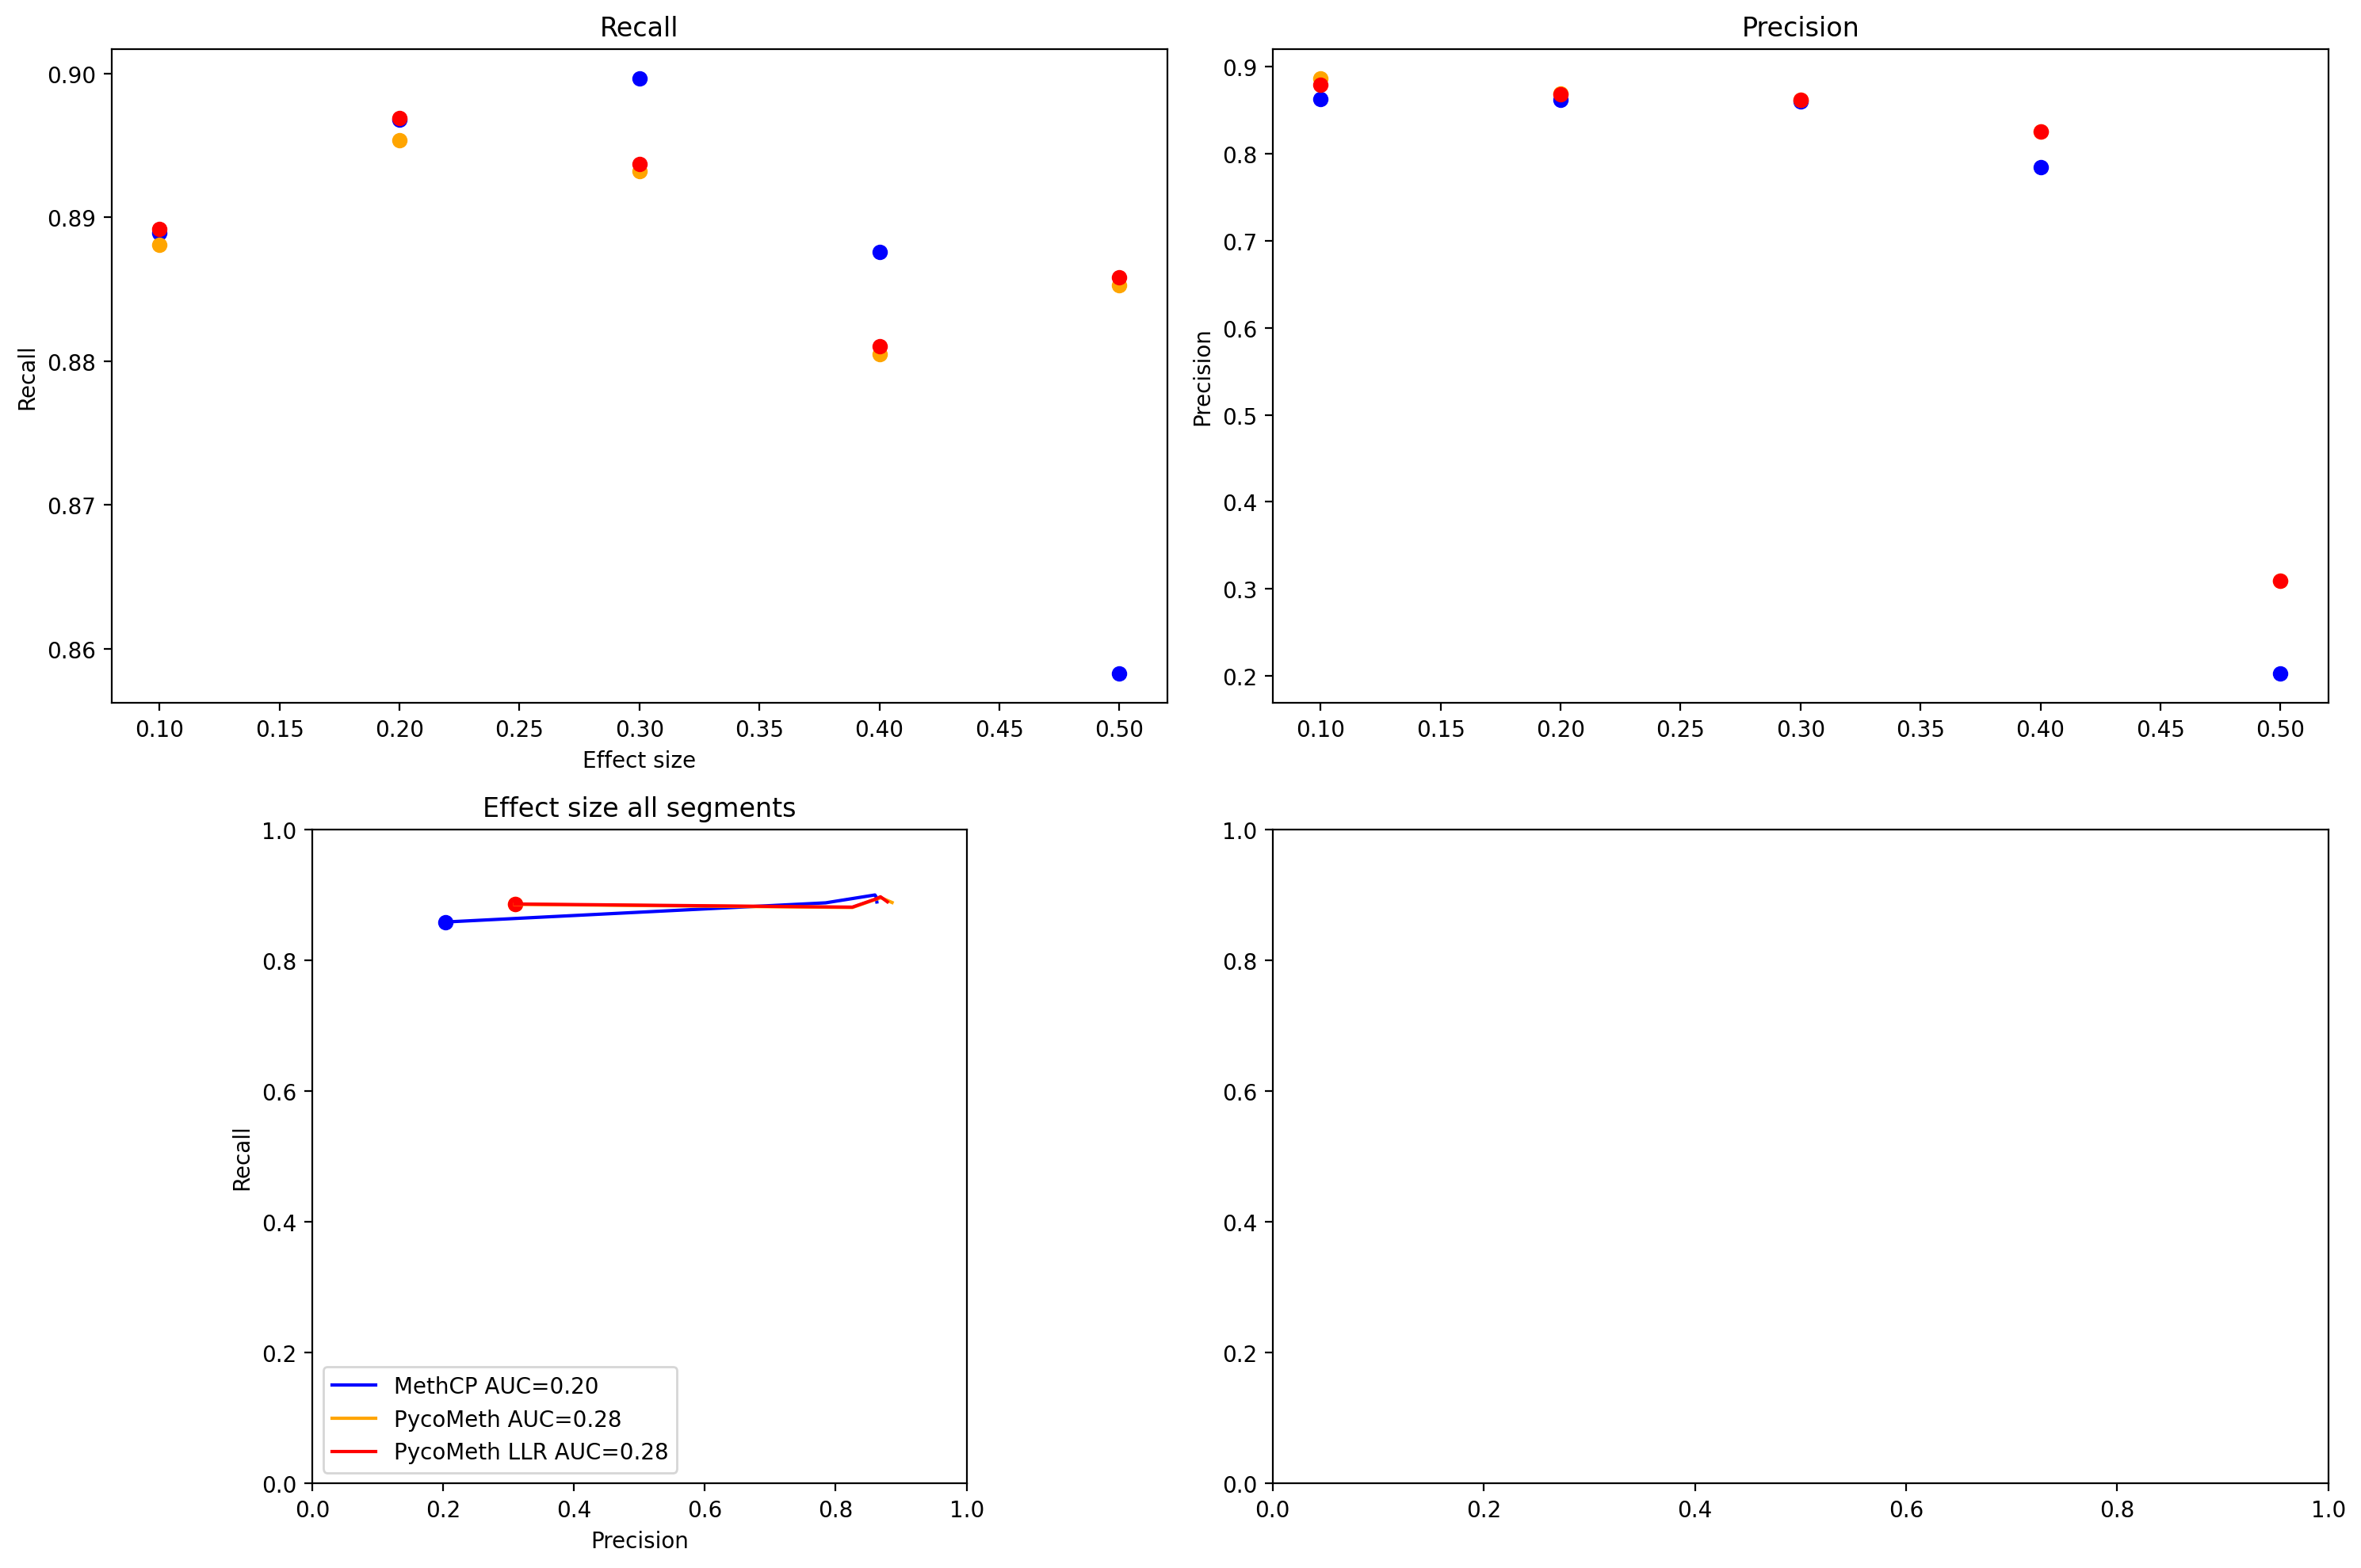

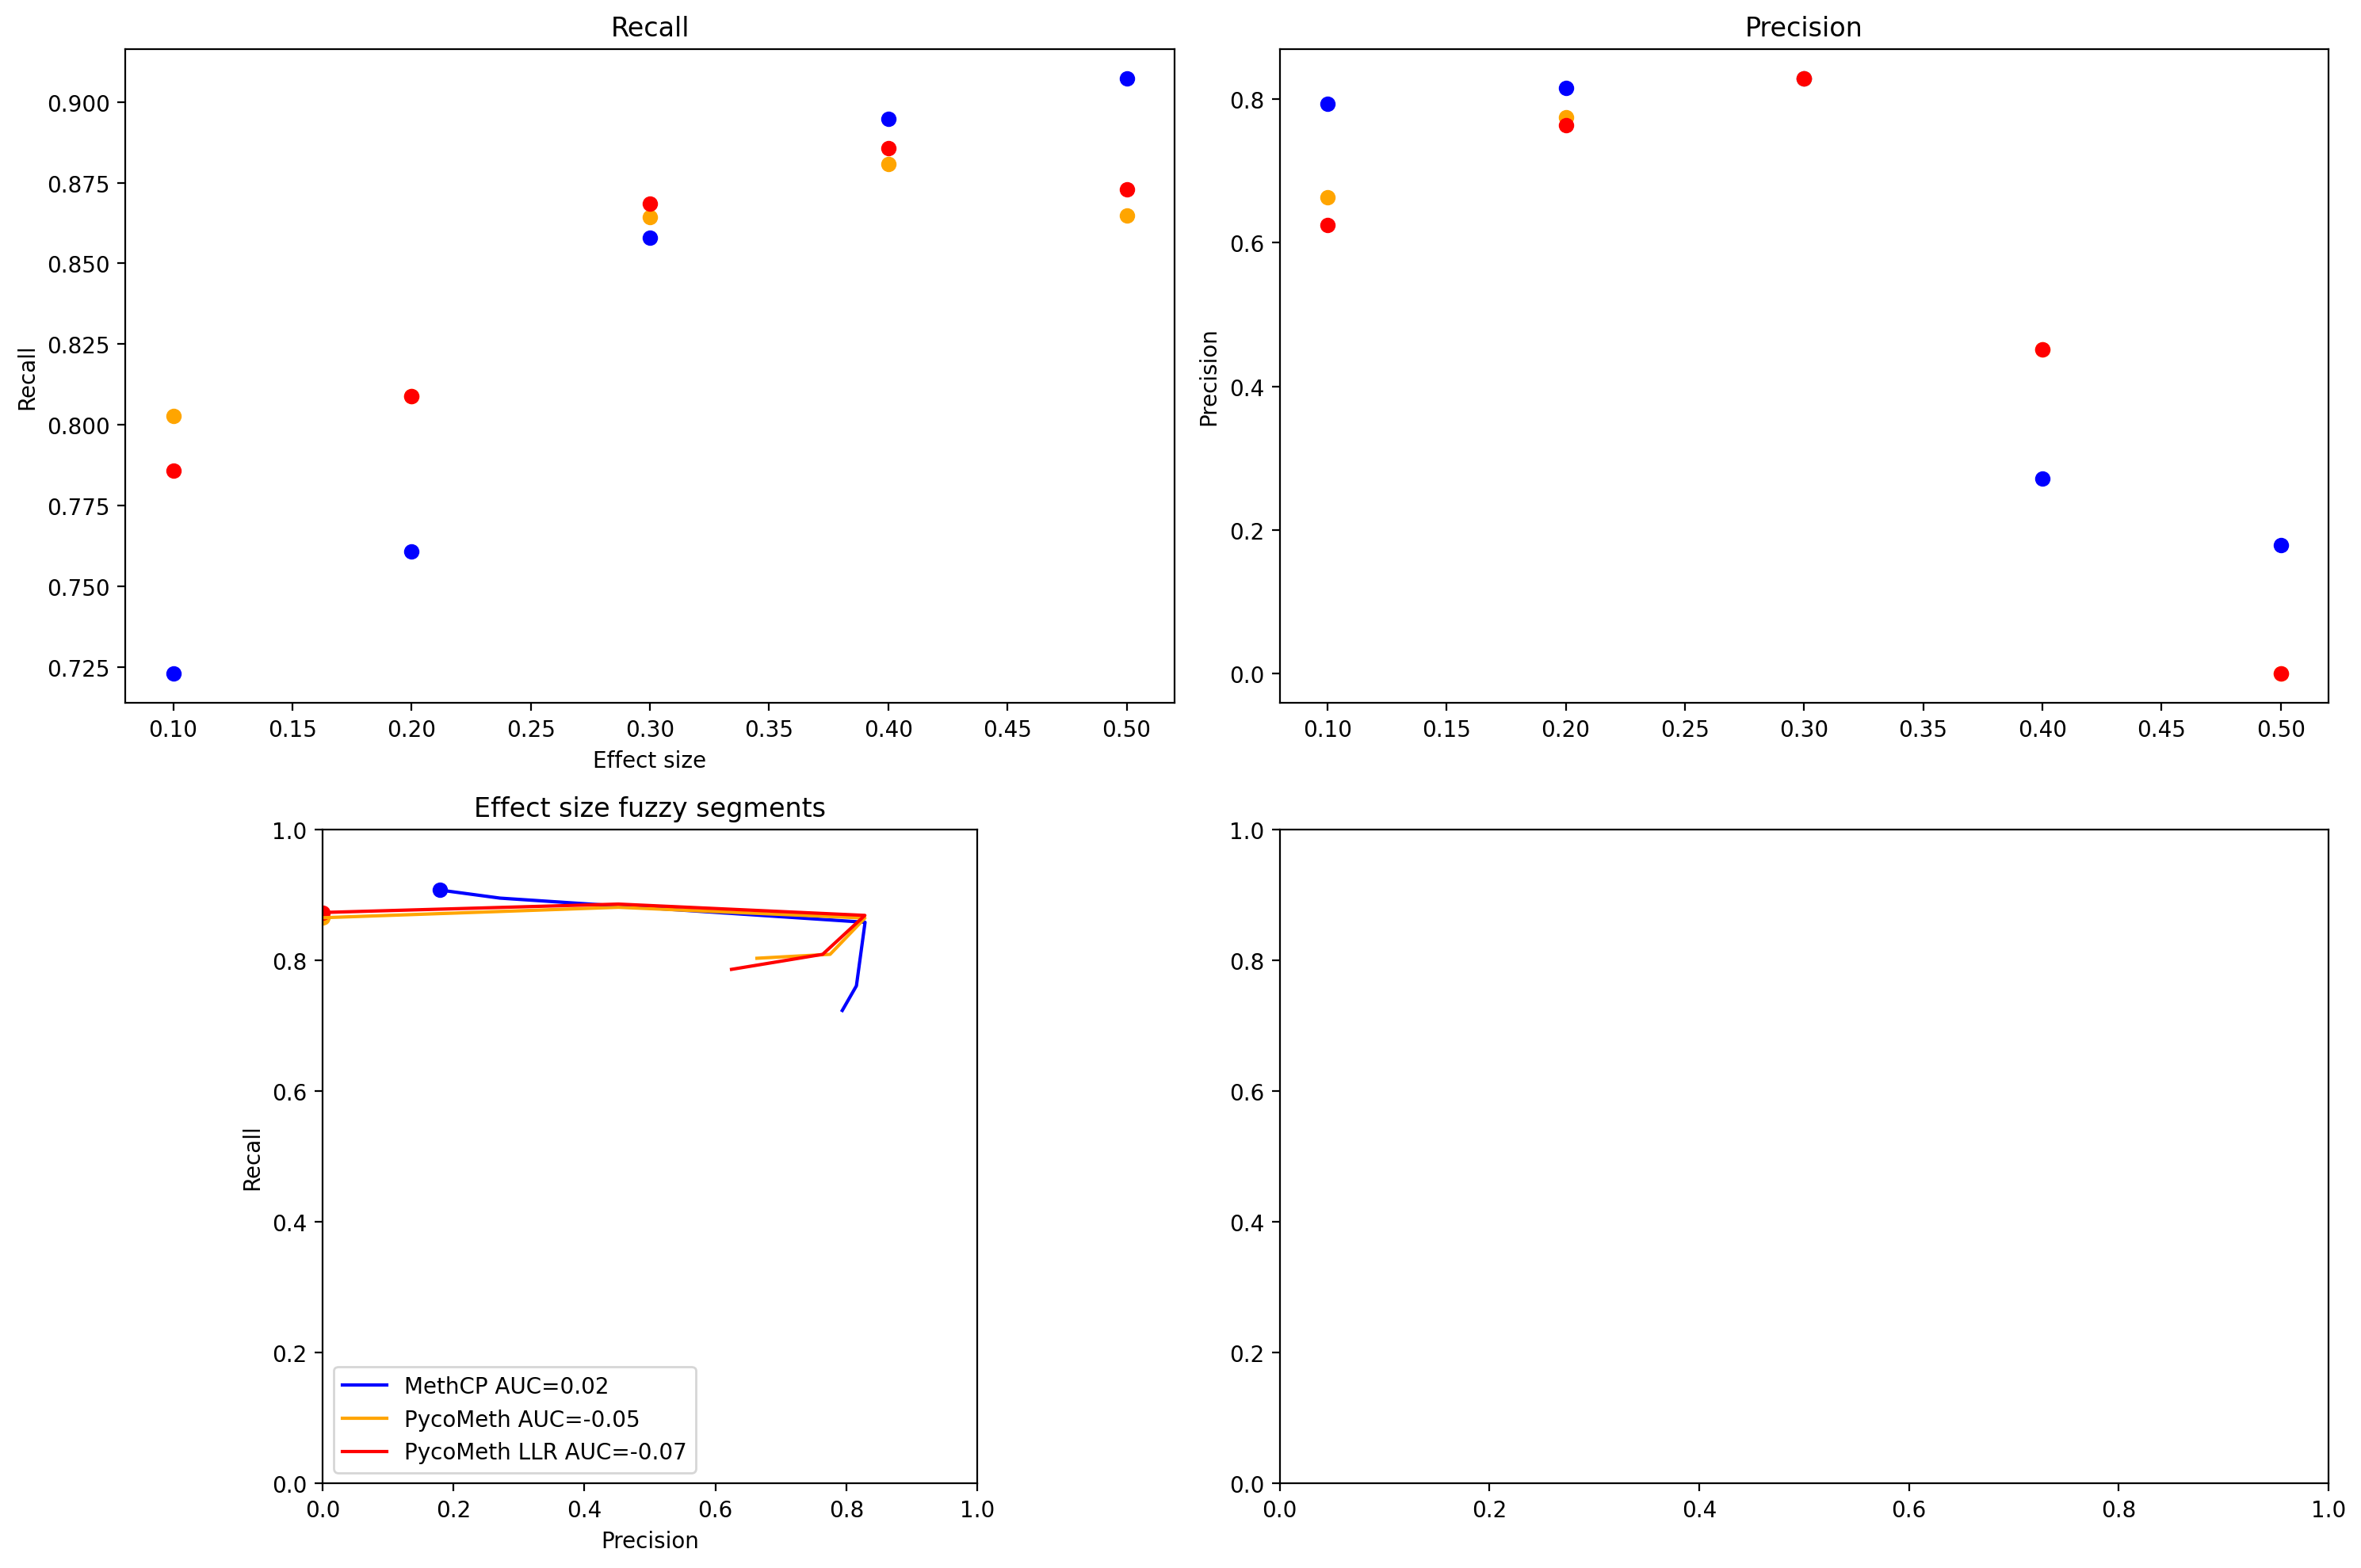

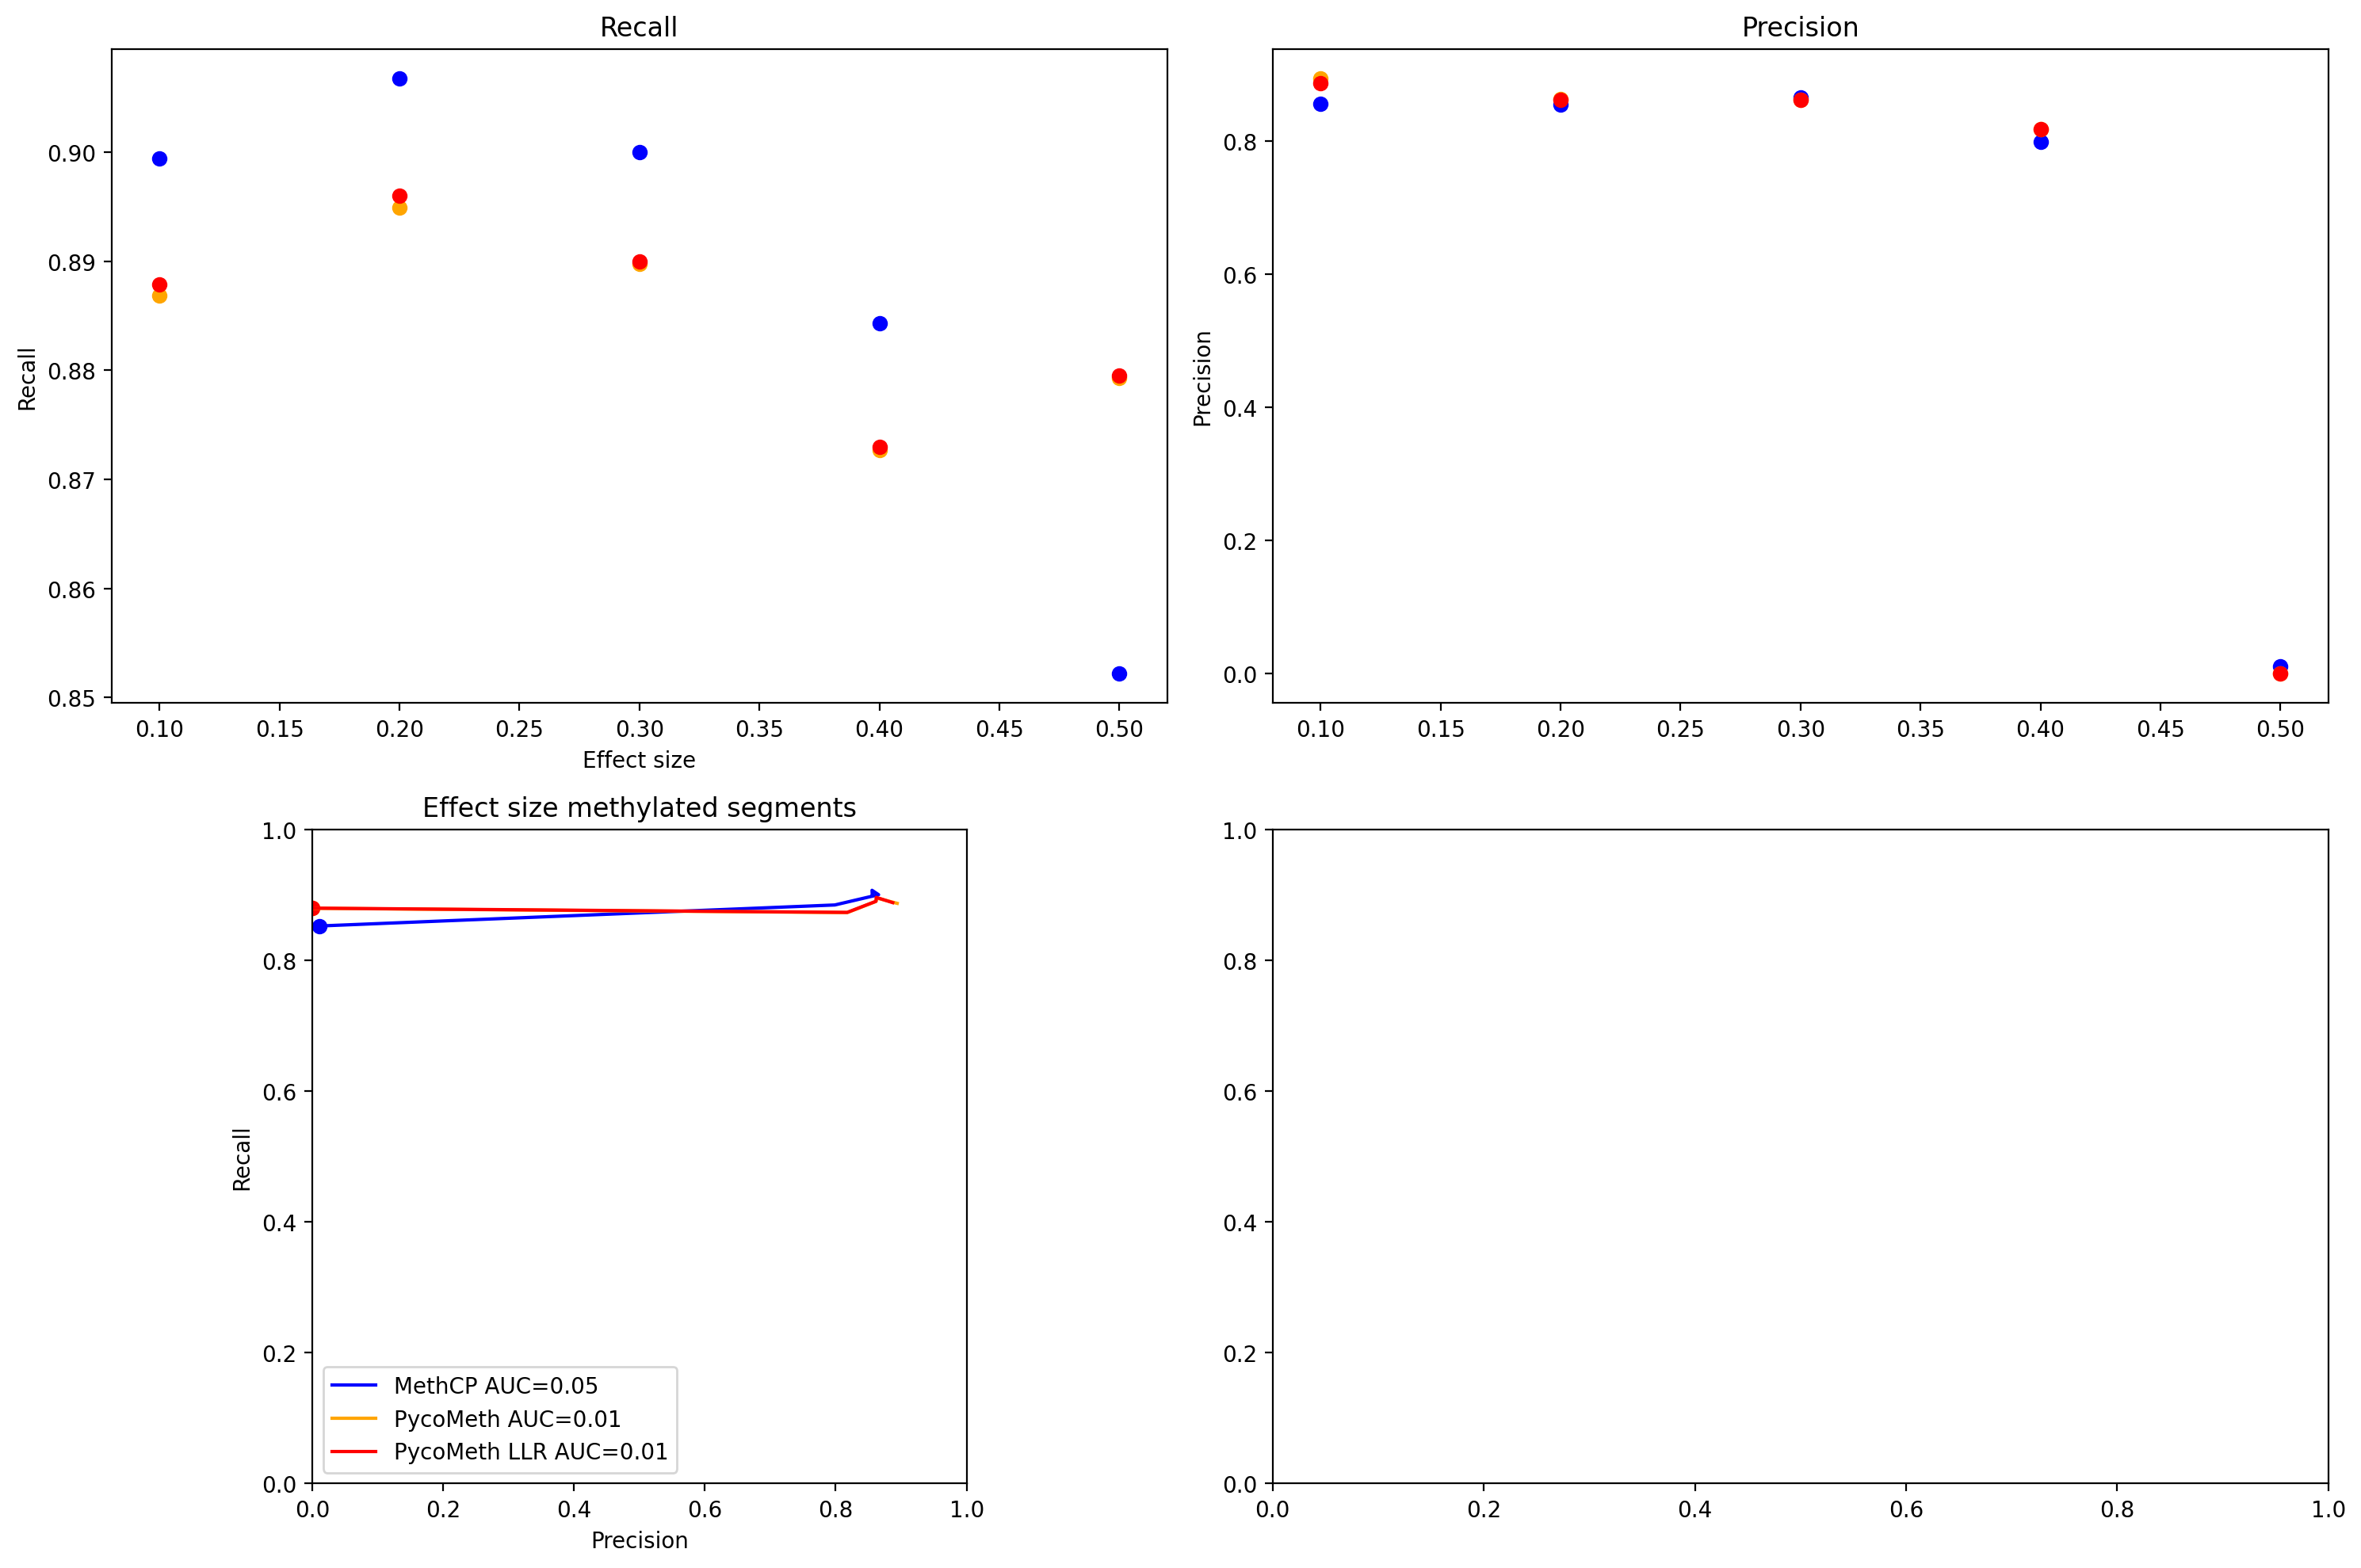

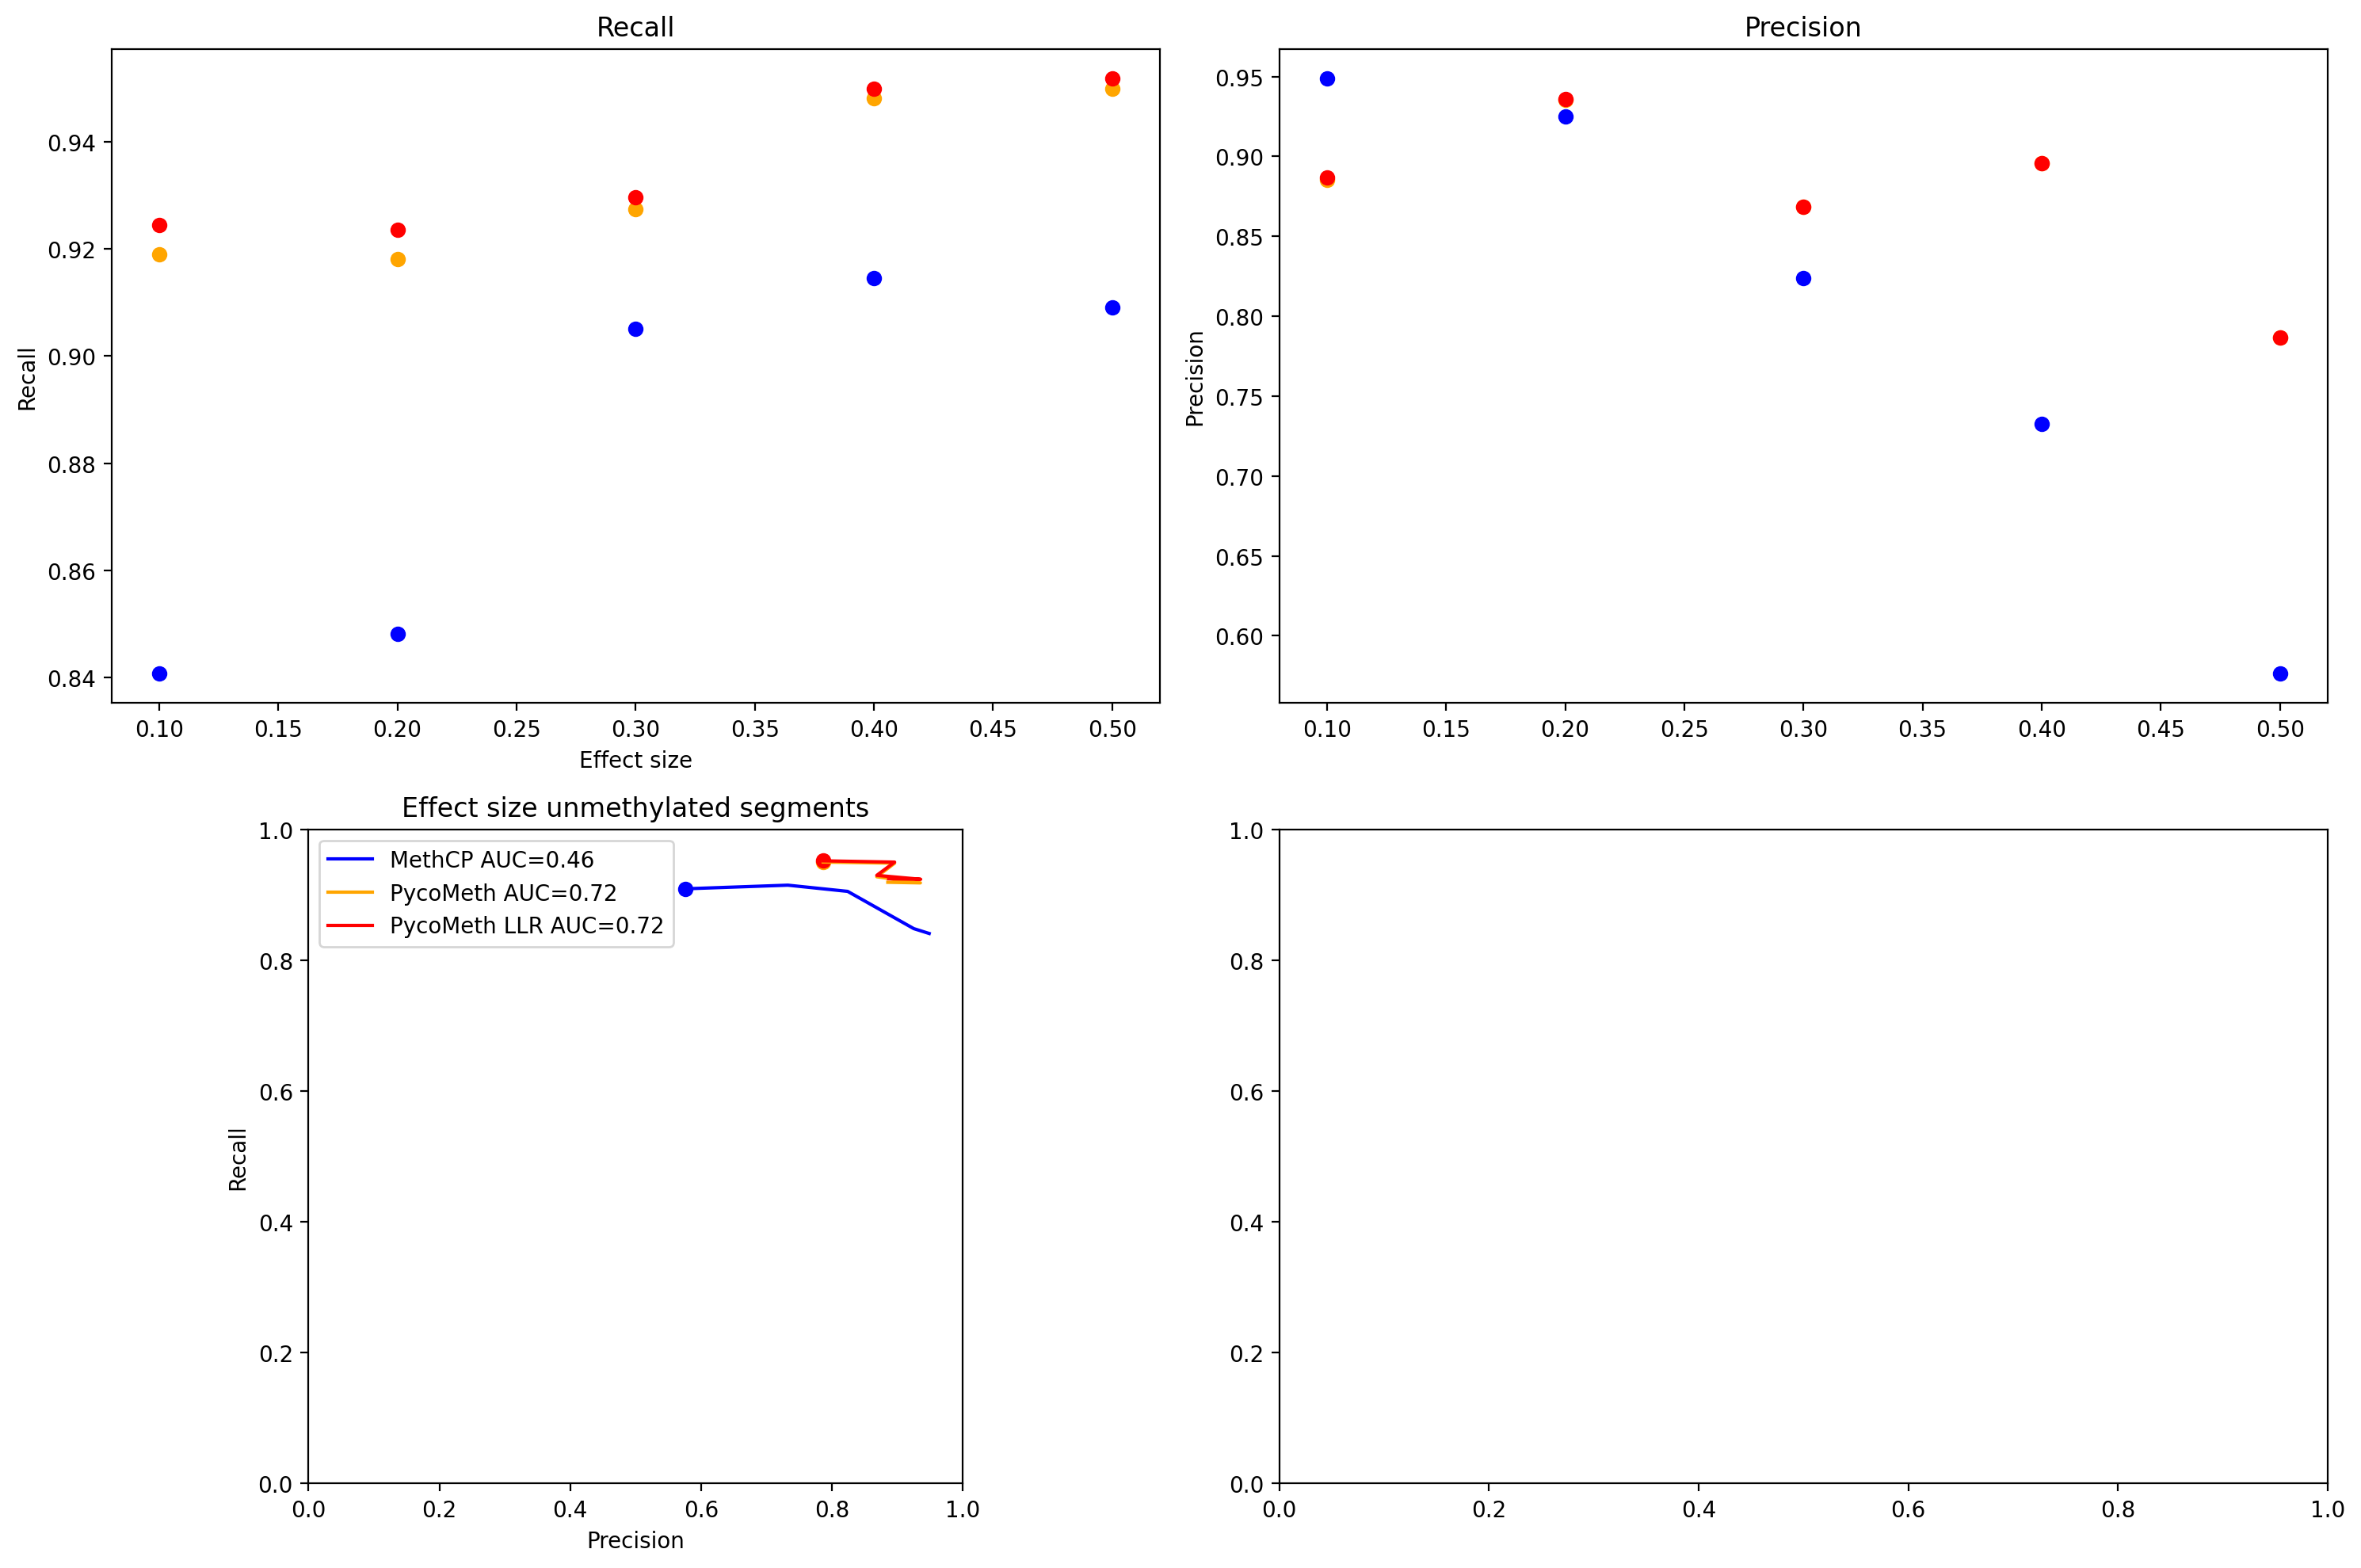

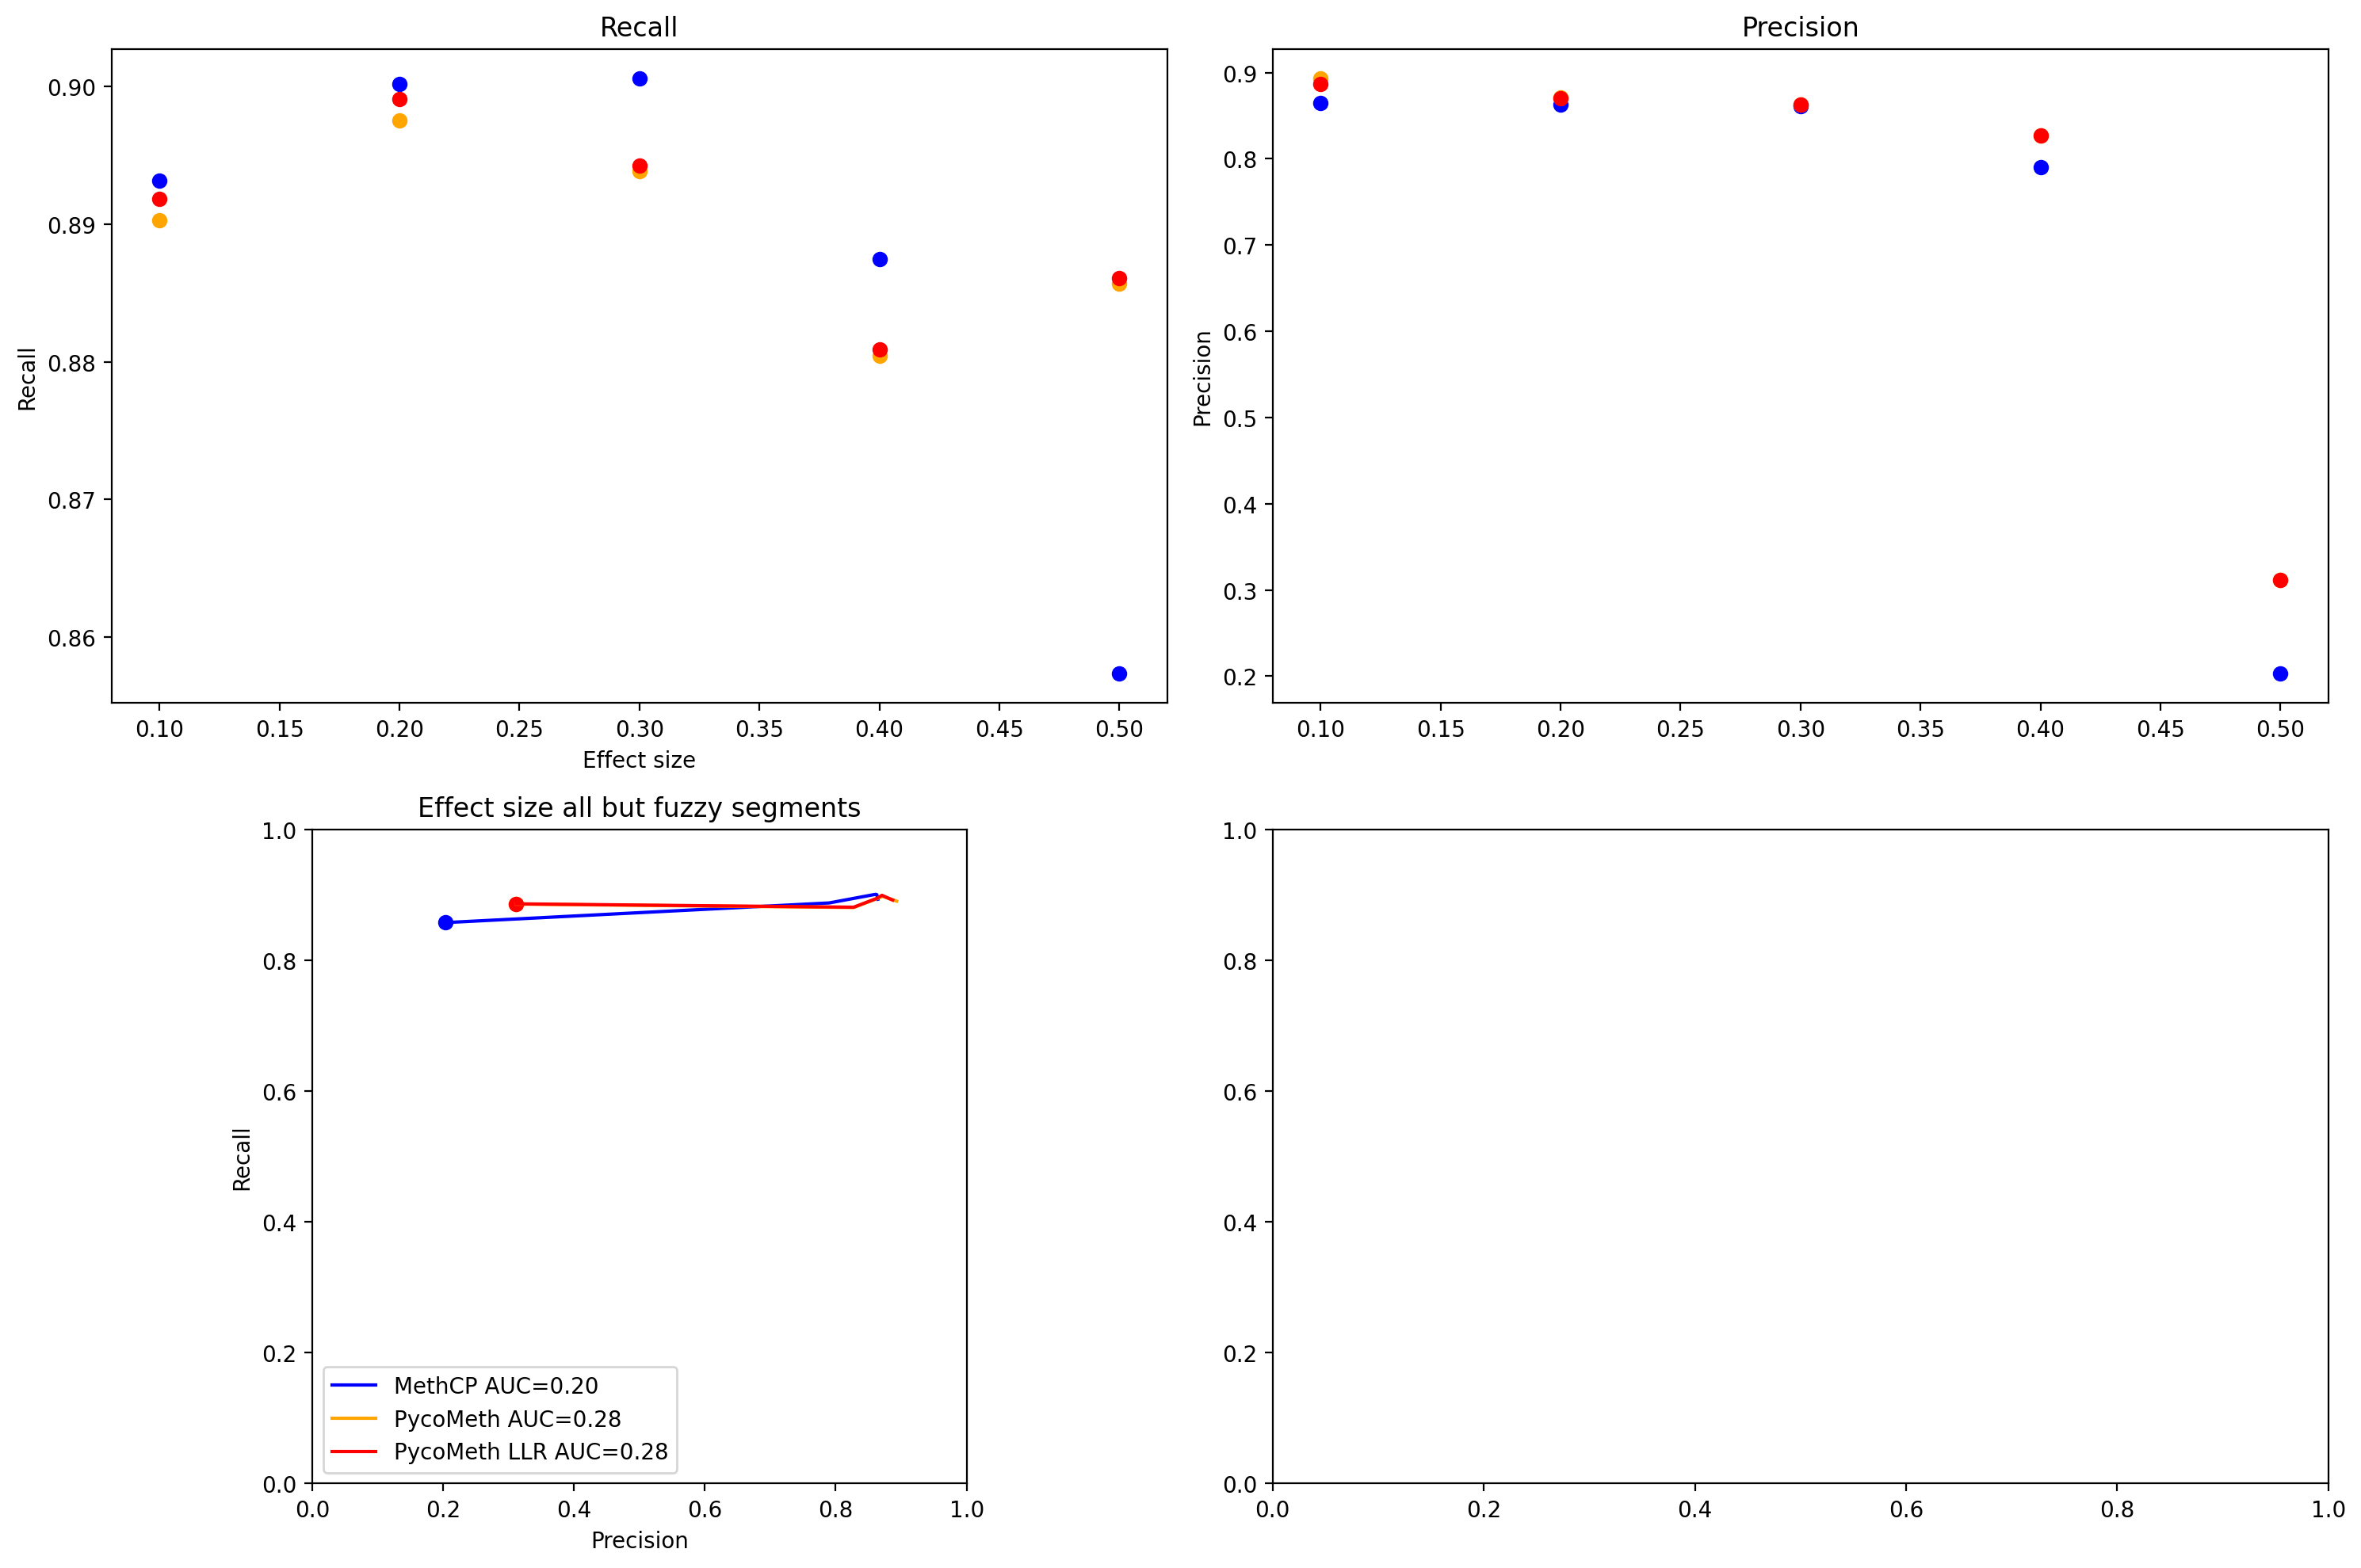

In [184]:
plot_roc_over_effect_size(gt, "Effect size all segments", "roc_effect_size_all")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==3].copy(), "Effect size fuzzy segments", "roc_fuzzy")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==2].copy(), "Effect size methylated segments", "roc_effect_size_methylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==1].copy(), "Effect size unmethylated segments", "roc_effect_size_unmethylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]!=3].copy(), "Effect size all but fuzzy segments", "roc_effect_size_notfuzzy")
